# Payne 2020

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part7.Comparison_to_Payne2020/'

In [4]:
! mkdir -p $FIGOUTDIR || true;

In [5]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
DEPTH_THRESHOLD = {'zygote': 3000, 'other': 5000}
IC_THRESHOLD = 1.4
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Load Kind data

## 1.1 Loading samplesheet

In [6]:
color_dict = ld.load_color_dict(COLORFN)

In [7]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno['treatment'] == 'no_treatment']
anno = anno[anno.cellcount == 1]
anno = anno[anno.genotype.isin(['homozygous', '129S1/SvImJ_x_CAST/EiJ', 'CBAB6F1_x_CAST/EiJ'])]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])


anno.head()

runid  illumina_index  damid2_adapter_number  \
damid_name                                                                      
KIN1971.index03.DamID2_BC_001  KIN1971               3                      1   
KIN1971.index03.DamID2_BC_009  KIN1971               3                      9   
KIN1971.index03.DamID2_BC_017  KIN1971               3                     17   
KIN1971.index03.DamID2_BC_025  KIN1971               3                     25   
KIN1971.index03.DamID2_BC_033  KIN1971               3                     33   

                               celseq2_adapter_number  cellcount construct  \
damid_name                                                                   
KIN1971.index03.DamID2_BC_001                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_009                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_017                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_025                       0          1     Lmnb1   
KIN1971.index03.DamID2_BC_033                       0          1     Lmnb1   

                              fusion_construct  stage     treatment  \
damid_name                                                            
KIN1971.index03.DamID2_BC_001        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_009        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_017        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_025        Dam-Lmnb1  2cell  no_treatment   
KIN1971.index03.DamID2_BC_033        Dam-Lmnb1  2cell  no_treatment   

                                 genotype  ... nTranscripts  \
damid_name                                 ...                
KIN1971.index03.DamID2_BC_001  homozygous  ...            0   
KIN1971.index03.DamID2_BC_009  homozygous  ...            0   
KIN1971.index03.DamID2_BC_017  homozygous  ...            0   
KIN1971.index03.DamID2_BC_025  homozygous  ...            0   
KIN1971.index03.DamID2_BC_033  homozygous  ...            0   

                              nTranscripts_maternal nTranscripts_paternal  \
damid_name                                                                  
KIN1971.index03.DamID2_BC_001                   NaN                   NaN   
KIN1971.index03.DamID2_BC_009                   NaN                   NaN   
KIN1971.index03.DamID2_BC_017                   NaN                   NaN   
KIN1971.index03.DamID2_BC_025                   NaN                   NaN   
KIN1971.index03.DamID2_BC_033                   NaN                   NaN   

                              allelic_celseq_balance nERCC nMito DamID_PASS  \
damid_name                                                                    
KIN1971.index03.DamID2_BC_001                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_009                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_017                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_025                    NaN     0     0       True   
KIN1971.index03.DamID2_BC_033                    NaN     0     0       True   

                               DamID_PASS_allelic CELseq_PASS stage_order  
damid_name                                                                 
KIN1971.index03.DamID2_BC_001                True       False           1  
KIN1971.index03.DamID2_BC_009                True       False           1  
KIN1971.index03.DamID2_BC_017                True       False           1  
KIN1971.index03.DamID2_BC_025                True       False           1  
KIN1971.index03.DamID2_BC_033                True       False           1  

[5 rows x 39 columns]

## 1.2 Loading mappability

In [9]:
mapab = dict()

for bs in [1e5, 1e6]:
    bs = int(bs)
    mapab[bs] = ld.load_mappability(POSFN, MAPFN, chrom_order, bs)

## 1.3 Loading DamID data

__Contact Frequency__

In [10]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [11]:
contact_freq = dict()

for bs in [1e5, 1e6]:
    bs = int(bs)
    
    contact_freq[bs] =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'is_heterozygous', 'treatment']):

        # load combined
        gt_name = info[2] if not info[-2] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[4], genotype = gt_name, binsize=bs)
        name = (info[1], info[2])

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        contact_freq[bs]['combined'][name] =  load_count_file(fn)

        if info[-2]:
            for parent, gt in GENOTYPE2PARENT[info[2]].items():
                gt_name = info[2].replace('/','') + '.' + gt
                fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[4], genotype = gt_name, binsize=bs)
                contact_freq[bs][parent][name] =  load_count_file(fn)

## 1.4 Loading allele visibility

In [12]:
allele_filt_gt = dict()
allele_filt_total = dict()

for bs in [1e5, 1e6]:
    bs = int(bs)
    
    allele_filt_gt[bs] = dict()
    for gt in GENOTYPE2PARENT:
        fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=bs)
        allele_filt_gt[bs][gt] = dict()

        with h5py.File(fn, 'r') as f:
            for c in chrom_order:
                allele_filt_gt[bs][gt][c] = f[c][:].astype(bool)

    allele_filt_total[bs] = dict()
    for c in chrom_order:
        filt = np.array([allele_filt_gt[bs][gt][c] for gt in allele_filt_gt[bs]]).astype(int)
        filt = filt.sum(axis=0) == len(allele_filt_gt[bs].keys())
        allele_filt_total[bs][c] = filt

# 2. Loading Payne data

In [13]:
COLFN = '../../Payne2020/Payne2020_TableS3_column_description.Embryos.tsv'
payne_col_info = pd.read_table(COLFN)
payne_col_info.loc[26,'Column description']

'Haplotyped chromosome territory assignment based on SNPs and homolog imputation -1 = not haplotyped, 0 = maternal, 1 = paternal'

In [14]:
payne_col_info.loc[23,'Column description']

'Assignment to the maternal or paternal genome, -1 = not assigned, 0 = maternal, 1 = paternal,  2 = conflicting'

In [15]:
payne_col_info.loc[26,'Column description']

'Haplotyped chromosome territory assignment based on SNPs and homolog imputation -1 = not haplotyped, 0 = maternal, 1 = paternal'

In [16]:
payne_col_info

Column index          Column name  \
0              1            embryo_id   
1              2              cell_id   
2              3           cell_index   
3              4                stage   
4              5              amp_ind   
5              6             x_um_abs   
6              7             y_um_abs   
7              8             z_um_abs   
8              9                  chr   
9             10             chr_name   
10            11                  pos   
11            12          rel_chr_pos   
12            13              umi_rol   
13            14         purity_score   
14            15              umi_seq   
15            16               umi_cs   
16            17          match_score   
17            18             frag_len   
18            19              umi_ind   
19            20         hamming_dist   
20            21                   gt   
21            22           hap1_reads   
22            23           hap2_reads   
23            24       hap_assignment   
24            25              cluster   
25            26          cluster_hap   
26            27  cluster_hap_imputed   
27            28               inlier   
28            29        dist_to_lamin   
29            30          dist_to_npb   
30            31              npb_ind   
31            32          dist_to_cen   
32            33              cen_ind   
33            34      compartment_ind   
34            35            lads_both   
35            36             lads_mat   
36            37             lads_pat   
37            38                   gc   

                                   Column description  
0                       Unique embryo index from 1-57  
1                        Unique cell index per embryo  
2          Unique cell index for all data, from 1-113  
3                                 Developmental stage  
4                      Unique amplicon index per cell  
5   Spatial location of read in the x dimension re...  
6   Spatial location of read in the y dimension re...  
7   Spatial location of read in the z dimension re...  
8                   Chromosome of mm10 read alignment  
9                  Name of chromosome from chr column  
10            Genomic position of mm10 read alignment  
11  Genomic position from pos column divided by si...  
12  Consensus sequence of the UMI from the in situ...  
13  Measure of the consensus UMI quality from in s...  
14       Genomic sequence of the closest matching UMI  
15    Colorspace sequence of the closest matching UMI  
16  Measure of the closest matching UMI quality fr...  
17         Length of the genomic insert in base pairs  
18           Unique UMI index from ex situ sequencing  
19  Number of bases that differ between consensus ...  
20  The bases at genomic positions where the read ...  
21  The number of SNPs in the read unique to the m...  
22  The number of SNPs in the read unique to the p...  
23  Assignment to the maternal or paternal genome,...  
24  Chromosome territory assignment based on MLE o...  
25  Haplotyped chromosome territory assignment bas...  
26  Haplotyped chromosome territory assignment bas...  
27  Position of read relative to chromosome territ...  
28      Spatial distance to nuclear lamina in microns  
29  Spatial distance to nearest nucleolus precurso...  
30  Unique index of nucleolus precursor body per cell  
31  Spatial distance to nearest centromere in microns  
32  Unique index of nucleolus precursor body per cell  
33  A/B compartment annotation from Du et al., -1 ...  
34  Lamina-associated domain annotation from Borso...  
35  Lamina-associated domain annotation from Borso...  
36  Lamina-associated domain annotation from Borso...  
37                   GC % in nearest 1 Mb genomic bin

In [17]:
FN = '../../Payne2020/Payne2020_TableS2_Embryo_data.tsv.gz'
payne = pd.read_table(FN)

In [18]:
payne = payne.rename(columns={'chr_name': 'chrom'})
payne = payne[~payne.chrom.isin(['chrM', 'unlocalized', 'unplaced', 'multi_umi'])]

tmp = lambda a: {-1: 'unknown', 0: 'maternal', 1: 'paternal'}[a]
payne['allele'] = payne['cluster_hap_imputed'].apply(func = tmp)
payne['chrom'] = payne.chrom.apply(func = lambda c: c.strip('chr') )

In [19]:
remove_cols = [
    'chr', 'amp_ind', 
    'umi_rol', 'purity_score', 'umi_seq', 'umi_cs', 'umi_ind', 'match_score', 'umi_ind', 'hamming_dist',
    'gt', 'hap1_reads', 'hap2_reads', 'cluster_hap', 'cluster_hap_imputed', 'hap_assignment'
]
remove_cols = np.intersect1d(remove_cols, payne.columns.values)

payne = payne.drop(columns=remove_cols)

# 1. Characterizing Payne data

## Number of unique fragments per cell

<Axes: xlabel='stage', ylabel='N'>

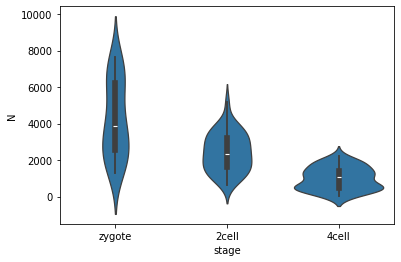

In [20]:
to_plot = payne.groupby(['stage', 'embryo_id', 'cell_id']).size().reset_index().rename(columns={0: 'N'})
to_plot = to_plot[to_plot.N > 0]
sns.violinplot(x=to_plot['stage'], y=to_plot['N'], order=['zygote', '2cell', '4cell'])

## Average number of reads per 1Mb for all cells

In [21]:
to_plot

stage  embryo_id  cell_id     N
0     2cell         25        1   636
1     2cell         25        2   881
2     2cell         26        1  1875
3     2cell         26        2  1677
4     2cell         27        1  2882
..      ...        ...      ...   ...
108  zygote         20        1  4282
109  zygote         21        1  6674
110  zygote         22        1  1949
111  zygote         23        1  3067
112  zygote         24        1  5567

[113 rows x 4 columns]

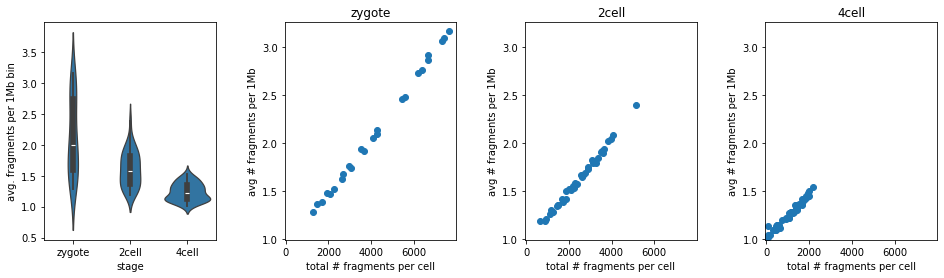

In [22]:
res = int(1e6)

to_plot = payne.copy()
to_plot['bin'] = (to_plot['pos'] // res).astype(int)
chrl = {c: len(mapab[res][c])*res for c in chrom_order}
all_bins = pd.DataFrame({
    'chrom': np.concatenate([np.repeat(c, int(np.ceil(chrl[c]/res))) for c in chrom_order]),
    'bin': np.concatenate([np.arange(0, int(np.ceil(chrl[c]/res))) for c in chrom_order])
})
to_plot = to_plot.groupby(['stage', 'embryo_id', 'cell_id', 'chrom', 'bin']).size().reset_index().rename(columns={0: 'N_per_bin'})
to_plot = to_plot.merge(all_bins, how='right').fillna(0)

tmp = payne.copy()
tmp = tmp.groupby(['embryo_id', 'cell_id']).size().reset_index().rename(columns={0: 'N_per_cell'})

to_plot = to_plot.merge(tmp).drop(columns=['chrom', 'bin'])
to_plot = to_plot.groupby(['stage', 'embryo_id', 'cell_id', 'N_per_cell']).mean().reset_index()

fig, axes = plt.subplots(1,4,figsize=(16,4))
plt.subplots_adjust(wspace=.4)

ax = axes[0]
sns.violinplot(x=to_plot['stage'], y=to_plot['N_per_bin'], order=['zygote', '2cell', '4cell'], ax=ax)
ax.set_ylabel('avg. fragments per 1Mb bin')
ax.set_xlabel('stage')

counter = 1

for stage in ['zygote', '2cell', '4cell']:
    ax = axes[counter]
    counter += 1
    
    df = to_plot[to_plot.stage==stage]
    
    X = df['N_per_cell']
    Y = df['N_per_bin']
    
    ax.scatter(X, Y)
    ax.set_title(stage)
    ax.set_xlabel('total # fragments per cell')
    ax.set_ylabel('avg # fragments per 1Mb')
    
yrange = np.array([ax.get_ylim() for ax in axes[1:]])
xrange = np.array([ax.get_xlim() for ax in axes[1:]])
for ax in axes[1:]:
    ax.set_xlim(xrange.min(axis=0)[0], xrange.max(axis=0)[1])
    ax.set_ylim(yrange.min(axis=0)[0], yrange.max(axis=0)[1])

## Average number of fragments per 200kb for stage populations

Text(0, 0.5, 'avg. # fragments per 200kb')

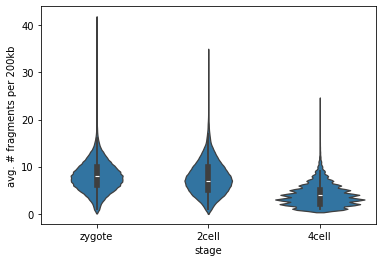

In [23]:
res = 2e5
damid_binsize = 1e5
to_plot = payne.copy()
to_plot['stage'] = to_plot['stage'].astype(str)
to_plot['bin'] = (to_plot['pos'] // res).astype(int)

chrl = {c: len(mapab[damid_binsize][c])*damid_binsize for c in chrom_order}
all_bins = pd.DataFrame({
    'chrom': np.concatenate([np.repeat(c, int(np.ceil(chrl[c]/res))) for c in chrom_order]),
    'bin': np.concatenate([np.arange(0, int(np.ceil(chrl[c]/res))) for c in chrom_order])
})


to_plot = to_plot.groupby(['stage', 'chrom', 'bin']).size().reset_index().rename(columns={0:'N'})
to_plot = to_plot.merge(all_bins, how='right').fillna(0)

to_plot.groupby(['stage']).agg({'N': np.mean})

sns.violinplot(x=to_plot['stage'], y=to_plot['N'], order=['zygote', '2cell', '4cell'])
plt.ylabel('avg. # fragments per 200kb')

# Relationship between CF and distance to the NL

In [24]:
NL_PROX_THRESH = 0.5

### Homozygous

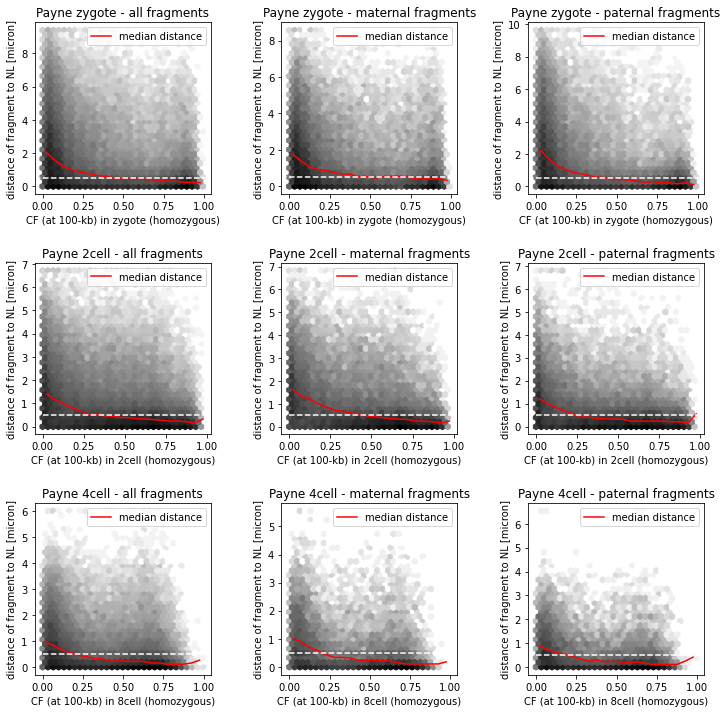

In [25]:
damid_binsize = int(1e5)

fig, axes = plt.subplots(3, 3, figsize=(12,12))
plt.subplots_adjust(hspace=.4, wspace=.4)

for irow, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot_all = payne[(payne.stage==stage)].copy()
    
    
    # add CF to dataframe
    to_plot_all['bin'] = to_plot_all['pos'] // damid_binsize
    cf_stage = stage if stage != '4cell' else '8cell'
    cf_stage = (cf_stage, 'homozygous')
    for chrom, df in to_plot_all.groupby('chrom'):
        to_plot_all.loc[df.index.values,'CF'] = contact_freq[damid_binsize]['combined'][cf_stage][chrom][df['bin'].values]
    to_plot_all['CF_step'] = to_plot_all['CF'] - (to_plot_all['CF'] % 0.05) + .025
    
    gt_to_plot = {
        'all': to_plot_all, 
        'maternal': to_plot_all[to_plot_all.allele=='maternal'], 
        'paternal': to_plot_all[to_plot_all.allele=='paternal']
    }
    
    icol = 0
    for gt, to_plot in gt_to_plot.items():
        
        ax = axes[irow,icol]
        icol += 1
        
        # plot relationship CF versus distance to lamina
        X = to_plot['CF'].values
        Y = to_plot['dist_to_lamin'].values
        mx = np.percentile(Y, 99.9)
        ax.hexbin(X, Y.clip(0,mx), bins='log', gridsize=30, mincnt=1, cmap='Greys')

        # plot average relationship
        tmp = to_plot.groupby('CF_step').agg({'dist_to_lamin': np.median})
        X = tmp.index.values
        Y = tmp.values.flatten()
        ax.plot(X, Y, c='r', label='median distance')

        ax.legend(loc='upper right')

        # format
        ax.set_ylabel('distance of fragment to NL [micron]')
        ax.set_xlabel('CF (at %d-kb) in %s (%s)' % (int(damid_binsize/1e3),cf_stage[0],cf_stage[1]))
        ax.set_title('Payne %s - %s fragments' % (stage, gt))
        
        ax.axhline(NL_PROX_THRESH, c='white', ls='--')
        
outfn = FIGOUTDIR + 'CF_versus_NLdist.homozygous_DamID_samples.DamID_binsize_%d.pdf' % damid_binsize
plt.savefig(outfn, bbox_inches='tight')

### Heterozygous - allelic

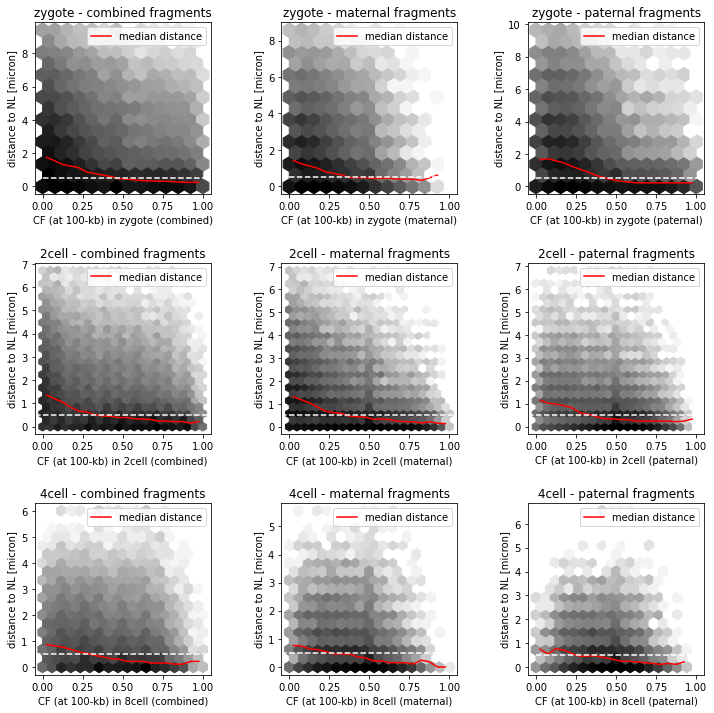

In [26]:
damid_binsize = int(1e5)

fig, axes = plt.subplots(3, 3, figsize=(12,12))
plt.subplots_adjust(hspace=.4, wspace=.4)

for irow, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot_all = payne[(payne.stage==stage)].copy()
    
    
    # add CF to dataframe
    to_plot_all['bin'] = to_plot_all['pos'] // damid_binsize
    cf_stage = stage if stage != '4cell' else '8cell'
    cf_stage = (cf_stage, 'CBAB6F1_x_CAST/EiJ')
    
    for allele in ['combined', 'maternal', 'paternal']:
        for chrom, df in to_plot_all.groupby('chrom'):
            to_plot_all.loc[df.index.values,'CF_%s' % allele] = contact_freq[damid_binsize][allele][cf_stage][chrom][df['bin'].values]
        to_plot_all['CF_%s_step' % allele] = to_plot_all['CF_%s' % allele] - (to_plot_all['CF_%s' % allele] % 0.05) + .025
    
    gt_to_plot = {
        'combined': to_plot_all, 
        'maternal': to_plot_all[to_plot_all.allele=='maternal'], 
        'paternal': to_plot_all[to_plot_all.allele=='paternal']
    }
    
    icol = 0
    for gt, to_plot in gt_to_plot.items():
        
        ax = axes[irow,icol]
        icol += 1
        
        ind = (anno.stage==cf_stage[0]) & (anno.genotype==cf_stage[1]) & anno.DamID_PASS_allelic
        nsamples = ind.sum()
        
        # plot relationship CF versus distance to lamina
        X = to_plot['CF_%s' % gt].values
        Y = to_plot['dist_to_lamin'].values
        mx = np.percentile(Y, 99.9)
        ax.hexbin(X, Y.clip(0,mx), extent=[0,1,0,mx], bins='log', gridsize=nsamples, mincnt=1, cmap='Greys')

        # plot average relationship
        tmp = to_plot.groupby('CF_%s_step' % gt).agg({'dist_to_lamin': np.median})
        X = tmp.index.values
        Y = tmp.values.flatten()
        ax.plot(X, Y, c='r', label='median distance')

        ax.legend(loc='upper right')

        # format
        ax.set_ylabel('distance to NL [micron]')
        ax.set_xlabel('CF (at %d-kb) in %s (%s)' % (int(damid_binsize/1e3), cf_stage[0], gt))
        ax.set_title('%s - %s fragments' % (stage, gt))
        
        ax.axhline(NL_PROX_THRESH, c='white', ls='--')
        
outfn = FIGOUTDIR + 'CF_versus_NLdist.hybrid_DamID_samples.DamID_binsize_%d.pdf' % damid_binsize
plt.savefig(outfn, bbox_inches='tight')

0.009259259259259259
0.005050505050505051
0.06666666666666667
0.037037037037037035
0.07142857142857142
0.045454545454545456
0.07142857142857142
0.045454545454545456


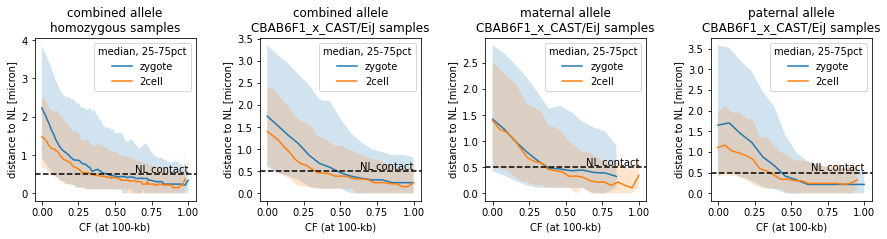

In [48]:
damid_binsize = int(1e5)

fig, axes = plt.subplots(1, 4, figsize=(15,3))
plt.subplots_adjust(hspace=.4, wspace=.4)

for icol, allele in enumerate(['homozygous', 'combined', 'maternal', 'paternal']):
    
    ax = axes[icol]
    
    gt = 'homozygous' if allele == 'homozygous' else 'CBAB6F1_x_CAST/EiJ'
    allele = 'combined' if allele == 'homozygous' else allele

    for stage in ['zygote', '2cell']:
        
        # select damid sample
        damid_stage = stage if (stage != '4cell') else '8cell'
        damid_sample = (damid_stage, gt)

        # collect data
        to_plot_all = payne[(payne.stage==stage)].copy()
        to_plot_all['bin'] = to_plot_all['pos'] // damid_binsize        
        for chrom, df in to_plot_all.groupby('chrom'):
            to_plot_all.loc[df.index.values,'CF'] = contact_freq[damid_binsize][allele][damid_sample][chrom][df['bin'].values]

        # select allele
        if allele != 'combined':
            to_plot_all = to_plot_all[to_plot_all['allele'] == allele]
            ind = (anno.stage==damid_sample[0]) & (anno.genotype==damid_sample[1]) & anno.DamID_PASS_allelic
        else:
            ind = (anno.stage==damid_sample[0]) & (anno.genotype==damid_sample[1]) & anno.DamID_PASS
        nsamples = ind.sum()

        # compute median
        
        cf_steps = np.linspace(0,1,nsamples+1)
        print(1/(nsamples+1))
        cf_window = 0.025
        cf_values = to_plot_all['CF'].values
        d_values = to_plot_all['dist_to_lamin'].values
        
        m_ls = list()
        p_25 = list()
        p_75 = list()
        for cf in cf_steps:
            ind = (cf_values > (cf-cf_window)) & (cf_values < (cf+cf_window))
            if ind.sum() < 20:
#                 print(cf, ind.sum())
                m_ls.append(np.nan)
                p_25.append(np.nan)
                p_75.append(np.nan)
            else:
                m_ls.append(np.median(d_values[ind]))
                p_25.append(np.percentile(d_values[ind],25))
                p_75.append(np.percentile(d_values[ind],75))
        m_ls = np.array(m_ls)
        p_25 = np.array(p_25)
        p_75 = np.array(p_75)
        ax.plot(cf_steps, m_ls, label=stage)
        ax.fill_between(cf_steps, p_25, p_75, alpha=0.2, lw=0)
        
    

    # format
    ax.set_title('%s allele\n%s samples' % (allele, gt))
    ax.legend(loc='upper right', title='median, 25-75pct')
    ax.set_ylabel('distance to NL [micron]')
    ax.set_xlabel('CF (at %d-kb)' % int(damid_binsize/1e3))
    ax.axhline(NL_PROX_THRESH, c='k', ls='--')
    ax.text(1, NL_PROX_THRESH, 'NL contact', ha='right', va='bottom')
        
outfn = FIGOUTDIR + 'CF_versus_NLdist.all_DamID_samples.lineplot.DamID_binsize_%d.pdf' % damid_binsize
plt.savefig(outfn, bbox_inches='tight')

# Distribution of NL-distances per CF category

### Homozygous

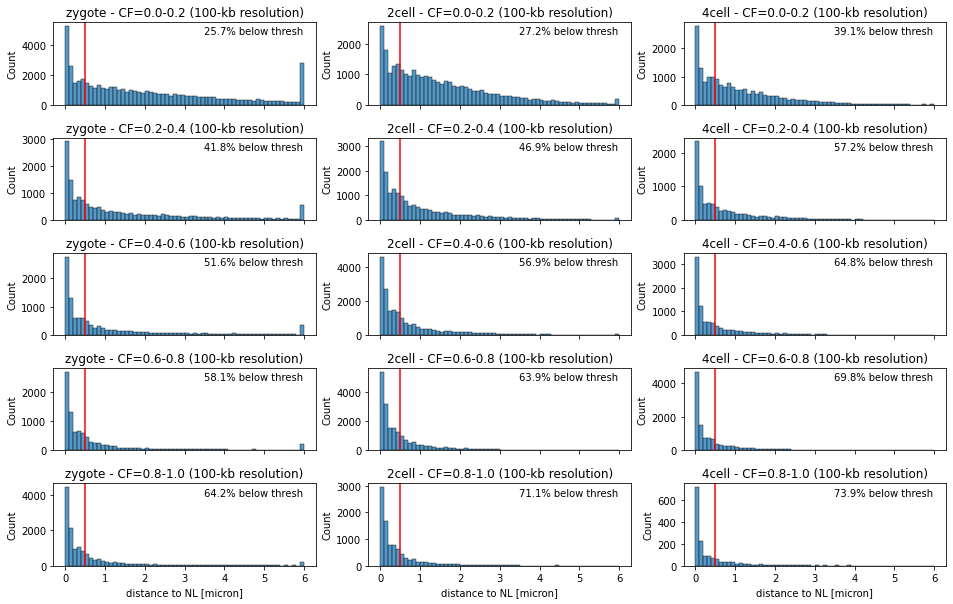

In [27]:
fig, axes = plt.subplots(5, 3, figsize=(16,10), sharex=True)
plt.subplots_adjust(hspace=.4)

for icol, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot = payne[(payne.stage==stage)].copy()
    
    # add CF to dataframe
    to_plot['bin'] = to_plot['pos'] // damid_binsize
    cf_stage = stage if stage != '4cell' else '8cell'
    cf_stage = (cf_stage, 'homozygous')
    for chrom, df in to_plot.groupby('chrom'):
        to_plot.loc[df.index.values,'CF'] = contact_freq[damid_binsize]['combined'][cf_stage][chrom][df['bin'].values]
    to_plot['CF_step'] = to_plot['CF'] - (to_plot['CF'] % 0.2)
    
    irow = 0
    for cfcat, df in to_plot.groupby('CF_step'):
        
        ax = axes[irow, icol]
        irow += 1
        
        sns.histplot(df['dist_to_lamin'].clip(-1,6), ax=ax, binwidth=.1)
        ax.set_title('%s - CF=%.1f-%.1f (%d-kb resolution)' % (stage, cfcat, cfcat+.2, int(damid_binsize/1e3)))
        ax.set_xlabel('distance to NL [micron]')
        ax.axvline(NL_PROX_THRESH, c='r')
        
        p = (df['dist_to_lamin'] < NL_PROX_THRESH).mean()*100
        ax.text(0.95, 0.95, '{:.1f}% below thresh'.format(p), transform=ax.transAxes, ha='right', va='top')

### Heterozygous - allelic

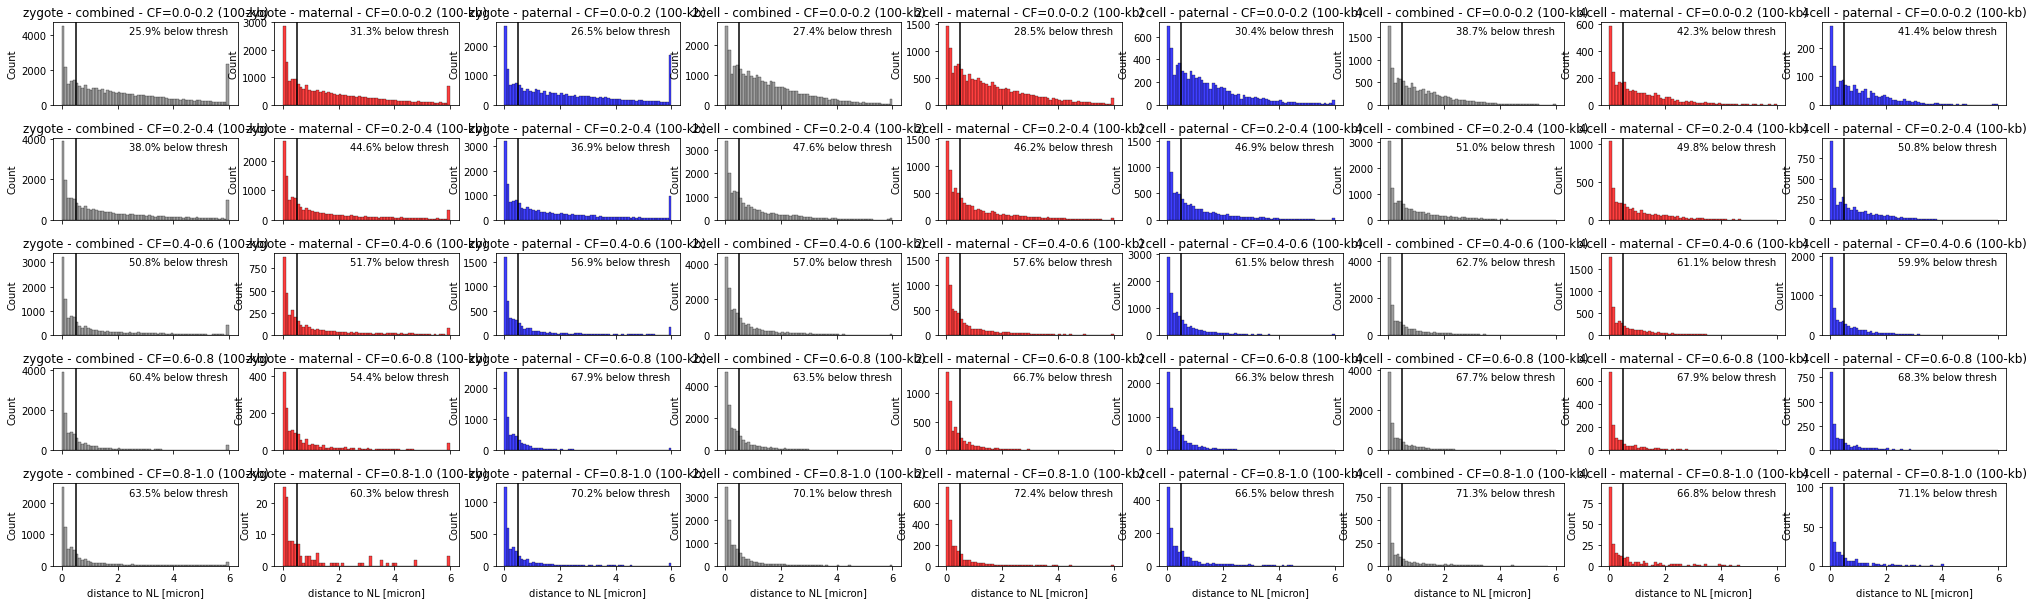

In [28]:
fig, axes = plt.subplots(5, 9, figsize=(35,10), sharex=True)
plt.subplots_adjust(hspace=.4)
c_counter = -1

for stage in ['zygote', '2cell', '4cell']:
    
    
    for allele in ['combined', 'maternal', 'paternal']:
        c_counter += 1
        
        to_plot = payne[(payne.stage==stage)].copy()
        if allele != 'combined':
            to_plot = to_plot[to_plot.allele==allele]

        # add CF to dataframe
        to_plot['bin'] = to_plot['pos'] // damid_binsize
        cf_stage = stage if stage != '4cell' else '8cell'
        cf_stage = (cf_stage, 'CBAB6F1_x_CAST/EiJ')
        for chrom, df in to_plot.groupby('chrom'):
            to_plot.loc[df.index.values,'CF'] = contact_freq[damid_binsize][allele][cf_stage][chrom][df['bin'].values]
        to_plot['CF_step'] = to_plot['CF'] - (to_plot['CF'] % 0.2)

        irow = 0
        for cfcat, df in to_plot.groupby('CF_step'):

            ax = axes[irow, c_counter]
            irow += 1
            
            clr = {'combined': 'grey', 'maternal': 'red', 'paternal': 'blue'}[allele]

            sns.histplot(df['dist_to_lamin'].clip(-1,6), ax=ax, binwidth=.1, color=clr)
            ax.set_title('%s - %s - CF=%.1f-%.1f (%d-kb)' % (stage, allele, cfcat, cfcat+.2,int(damid_binsize/1e3)))
            ax.set_xlabel('distance to NL [micron]')
            ax.axvline(NL_PROX_THRESH, c='k')
            
            p = (df['dist_to_lamin'] < NL_PROX_THRESH).mean()*100
            ax.text(0.95, 0.95, '{:.1f}% below thresh'.format(p), transform=ax.transAxes, ha='right', va='top')

# Relationship between CF and NL-contact (<0.5 micron)

### Homozygous

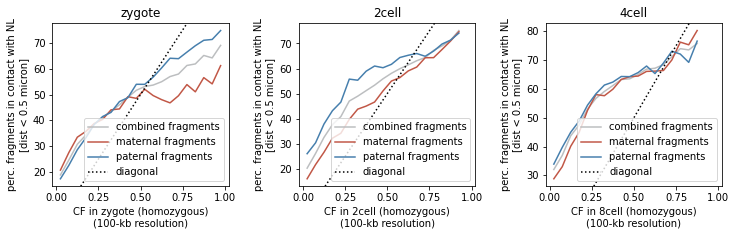

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), sharex=True)
plt.subplots_adjust(wspace=.4)


for icol, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot_all = payne[(payne.stage==stage)].copy()
    
    # add CF to dataframe
    to_plot_all['bin'] = to_plot_all['pos'] // damid_binsize
    cf_stage = stage if stage != '4cell' else '8cell'
    cf_stage = (cf_stage, 'homozygous')
    for chrom, df in to_plot_all.groupby('chrom'):
        to_plot_all.loc[df.index.values,'CF'] = contact_freq[damid_binsize]['combined'][cf_stage][chrom][df['bin'].values]
    to_plot_all['CF_step'] = to_plot_all['CF'] - (to_plot_all['CF'] % 0.05) + .025
    
    gt_to_plot = {
        'combined': to_plot_all, 
        'maternal': to_plot_all[to_plot_all.allele=='maternal'], 
        'paternal': to_plot_all[to_plot_all.allele=='paternal']
    }
    
    ax = axes[icol]
    for gt, to_plot in gt_to_plot.items():

        # plot average relationship
        tmp = to_plot.groupby('CF_step').agg({'dist_to_lamin': lambda d: (d < NL_PROX_THRESH).mean()})
        n = to_plot.groupby('CF_step').size()
        ind = n.values > 100
        X = tmp.index.values[ind]
        Y = tmp.values.flatten()[ind] * 100
        ax.plot(X, Y, c=color_dict['allele'][gt], label='%s fragments' % gt)

    # plot hypothetical diagonal
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    mn = max(xlim[0], ylim[0]/100)
    mx = min(xlim[1], ylim[1]/100)
    ax.plot([mn,mx], [mn*100,mx*100], c='k', ls=':', label='diagonal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.legend(loc='lower right')

    # format
    ax.set_ylabel('perc. fragments in contact with NL\n[dist < {:.1f} micron]'.format(NL_PROX_THRESH))
    ax.set_xlabel('CF in %s (%s)\n(%d-kb resolution)' % (cf_stage[0], cf_stage[1], int(damid_binsize/1e3)))
    ax.set_title(stage)
    
outfn = FIGOUTDIR + 'CF_versus_pctContact.homozygous_DamID_samples.DamID_binsize_%d.pdf' % damid_binsize
plt.savefig(outfn, bbox_inches='tight')

The different trend in CF as measured by microscopy and DamID may be due to:
- technical differences / thresholds, obviously
- Accummulative nature of DamID
- Fact that DamID is measuring four alleles at once

### Heterozygous - allelic

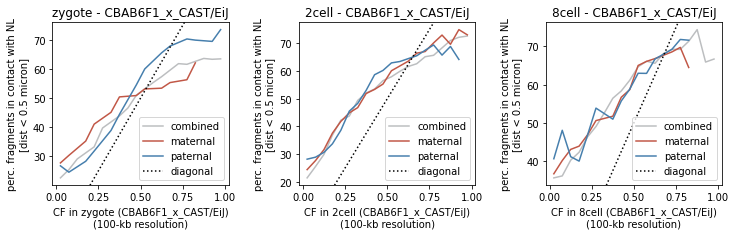

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), sharex=True)
plt.subplots_adjust(wspace=.4)

for icol, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot_all = payne[(payne.stage==stage)].copy()
    
    # add CF to dataframe
    to_plot_all['bin'] = to_plot_all['pos'] // damid_binsize
    cf_stage = stage if stage != '4cell' else '8cell'
    cf_stage = (cf_stage, 'CBAB6F1_x_CAST/EiJ')
    
    for allele in ['combined', 'maternal', 'paternal']:
        for chrom, df in to_plot_all.groupby('chrom'):
            to_plot_all.loc[df.index.values,'CF_%s' % allele] = contact_freq[damid_binsize][allele][cf_stage][chrom][df['bin'].values]
        to_plot_all['CF_%s_step' % allele] = to_plot_all['CF_%s' % allele] - (to_plot_all['CF_%s' % allele] % 0.05) + .025
    
    gt_to_plot = {
        'combined': to_plot_all, 
        'maternal': to_plot_all[to_plot_all.allele=='maternal'], 
        'paternal': to_plot_all[to_plot_all.allele=='paternal']
    }
    
    ax = axes[icol]
    for gt, to_plot in gt_to_plot.items():

        # plot average relationship
        tmp = to_plot.groupby('CF_%s_step' % gt).agg({'dist_to_lamin': lambda d: (d < NL_PROX_THRESH).mean()})
        n = to_plot.groupby('CF_%s_step' % gt).size()
        ind = n.values > 100
        X = tmp.index.values[ind]
        Y = tmp.values.flatten()[ind] * 100
        ax.plot(X, Y, c=color_dict['allele'][gt], label=gt)
        
    # plot hypothetical diagonal
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    mn = max(xlim[0], ylim[0]/100)
    mx = min(xlim[1], ylim[1]/100)
    ax.plot([mn,mx], [mn*100,mx*100], c='k', ls=':', label='diagonal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.legend(loc='lower right')

    # format
    ax.set_ylabel('perc. fragments in contact with NL\n[dist < {:.1f} micron]'.format(NL_PROX_THRESH))
    ax.set_xlabel('CF in %s (%s)\n(%d-kb resolution)'% (cf_stage[0], cf_stage[1], int(damid_binsize/1e3)))
    ax.set_title('%s - %s' % cf_stage)
    
    
outfn = FIGOUTDIR + 'CF_versus_pctContact.hybrid_DamID_samples.DamID_binsize_%d.pdf' % damid_binsize
plt.savefig(outfn, bbox_inches='tight')

# Function to generate tracks

In [31]:
def get_insilico_payne_track(to_plot, col, res, combine_as='median', thresh=NL_PROX_THRESH):

    # determine to which bin each fragment belongs
    to_plot['bin'] = (to_plot['pos'] // res).astype(int)

    # summarize values per bin
    if combine_as == 'CF':
        to_plot = to_plot.groupby(['chrom','bin']).agg({col: lambda c: (c<thresh).mean(), 'cell_index': len}).reset_index()
    elif combine_as == 'mean':
        to_plot = to_plot.groupby(['chrom','bin']).agg({col: np.mean, 'cell_index': len}).reset_index()
    elif combine_as == 'median':
        to_plot = to_plot.groupby(['chrom','bin']).agg({col: np.median, 'cell_index': len}).reset_index()
    to_plot = to_plot.rename(columns={'cell_index': 'n_fragments'})
        
        
    # add potential missing bins
    chromlens = {c: len(mapab[100000][c])*100000 for c in chrom_order}
    b = {c: np.arange(0, int(np.ceil(chromlens[c]/res))) for c in chrom_order}
    all_bins = pd.DataFrame({
        'chrom': np.concatenate([np.repeat(c, len(b[c])) for c in chrom_order]),
        'bin': np.concatenate([b[c] for c in chrom_order])
    })
    to_plot = all_bins.merge(to_plot, how='left')
    to_plot[col] = to_plot[col].fillna(0)
    to_plot['n_fragments'] = to_plot['n_fragments'].fillna(0).astype(int)
    to_plot = to_plot.sort_values(by=['chrom', 'bin'])

    return to_plot

# Distance to NL

In [32]:
def make_chrom_plot(chrom, feature='NL', damid_binsize=1000000):
    col = 'dist_to_lamin' if feature == 'NL' else 'dist_to_npb'
    res = 1e6
    combine_as = 'median' # median mean
    thresh = NL_PROX_THRESH
    allele = 'combined' # maternal paternal

    figw = 10 / len(mapab[damid_binsize]['1']) * len(mapab[damid_binsize][chrom])

    nrow = 12
    fig, axes = plt.subplots(nrow, 1, figsize=(figw, nrow*1.5), sharex=True)
    plt.subplots_adjust(hspace=.6)
    counter = 0

    for stage in ['zygote', '2cell', '4cell']:
        cf_stage = stage if stage != '4cell' else '8cell'
        genotypes = ['homozygous', 'CBAB6F1_x_CAST/EiJ']

        # plot CF - DamID
        for gt in genotypes:
            ax = axes[counter]
            counter += 1
            
            Y = contact_freq[damid_binsize]['combined'][(cf_stage, gt)][chrom]
            X = (np.arange(0, len(Y)*damid_binsize, damid_binsize) + (damid_binsize/2)) / 1e6
            
            if gt == 'homozygous':
                ax.fill_between(X, 0, Y, color='k', lw=0)
            else:
                ax.plot(X, Y, c='k', label='combined')
                for allele in ['maternal', 'paternal']:
                    Y = contact_freq[damid_binsize][allele][(cf_stage, gt)][chrom]
                    clr = color_dict['allele'][allele]
                    ax.fill_between(X, 0, Y, alpha=0.4, color=clr, lw=0)
                    
            ax.set_title('%s (%s) - DamID CF - %d-kb bins' % (cf_stage, gt, int(damid_binsize/1000)))
            ax.set_xlim(X[0], X[-1])
            ax.set_ylabel('CF')

        # plot median dist to lamin

        for combine_as in ['median', 'CF']:
            ax = axes[counter]
            counter += 1

            for allele in ['maternal', 'paternal', 'combined']:

                # select genotype of interest
                if allele == 'combined':
                    select_ind = (payne.stage == stage)
                else:
                    select_ind = (payne.stage == stage) & (payne['allele'] == allele)
                    
                to_plot = get_insilico_payne_track(payne[select_ind].copy(), col, res, combine_as, thresh)
                Y = to_plot.loc[to_plot.chrom==chrom, col].values
#                 Y = Y - Y.mean()
                X = (np.arange(0, len(Y)*res, res) + (res/2)) / 1e6
                clr = color_dict['allele'][allele]

                if allele == 'combined':
                    ax.plot(X, Y, c='k', label=allele)
                else:
                    ax.fill_between(X, 0, Y, alpha=.4, color=clr, label=allele)

            N = 'CF (dist < %.1f micron to %s)' % (thresh, feature) if combine_as == 'CF' else '%s dist. to %s' % (combine_as, feature)
            L = 'CF' if combine_as == 'CF' else 'dist. [micron]'
            ax.set_ylabel(L)
            ax.set_title('%s - IGS %s - %d-kb bins' % (stage, N, int(res/1000)))
            ax.legend(loc=(1,0))

    ax.set_xlabel('chromosome %s [Mb]' % chrom)
    plt.show()

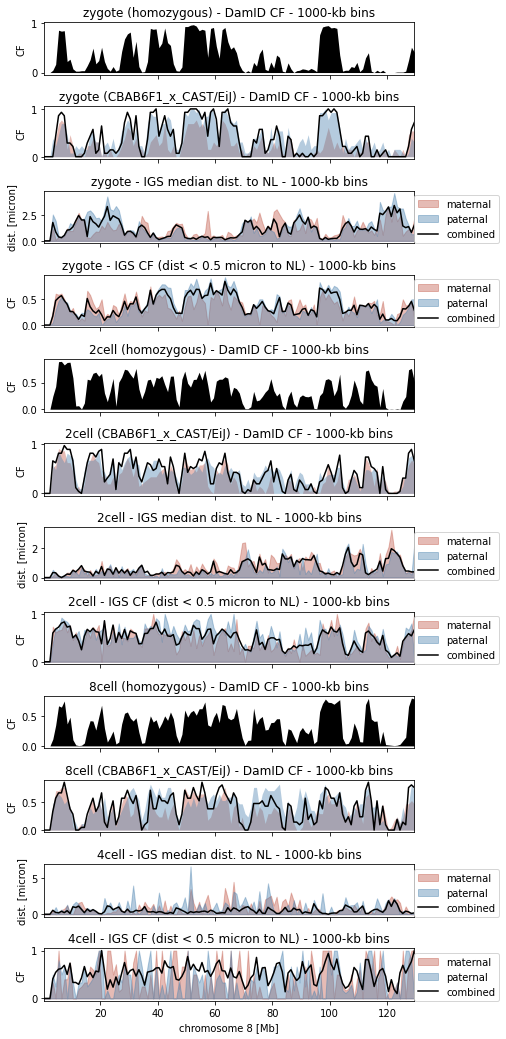

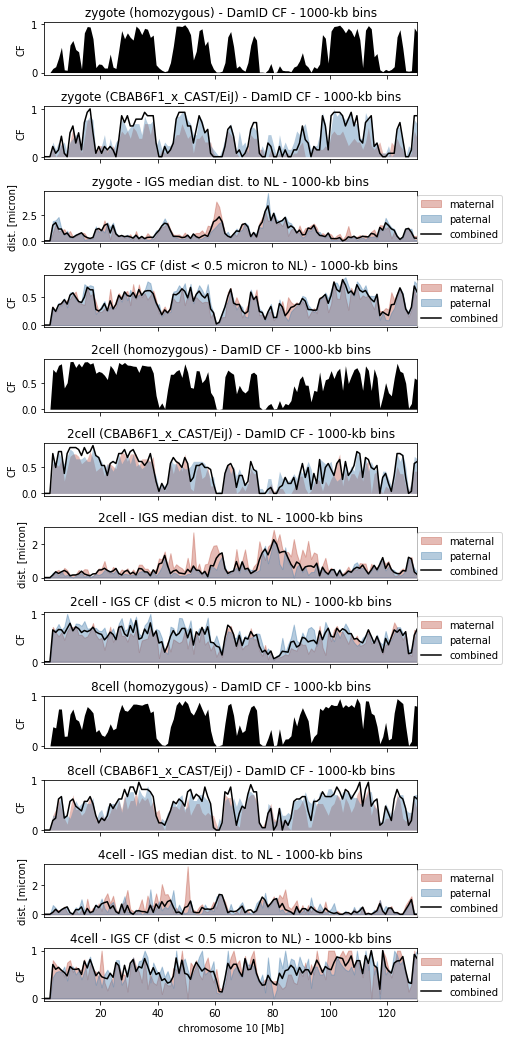

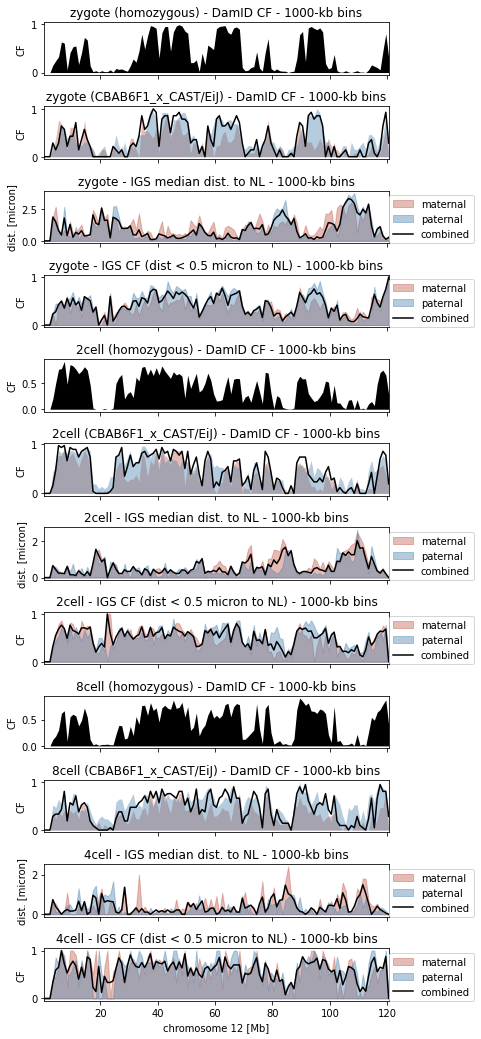

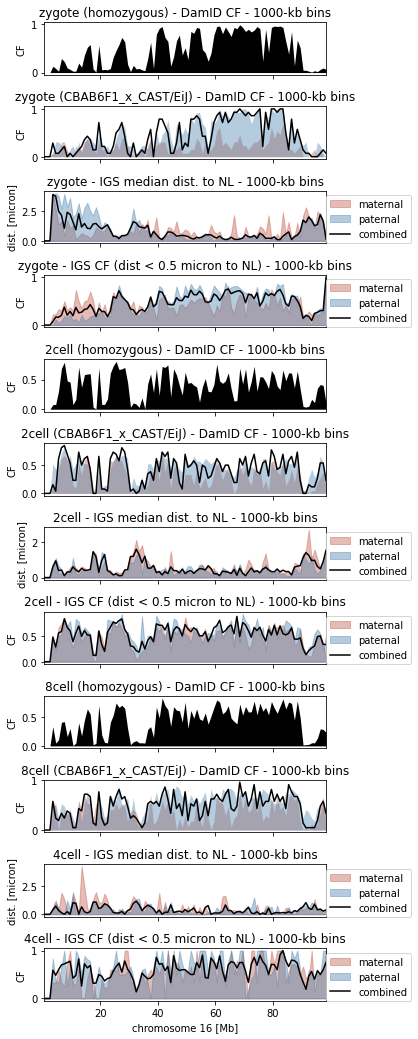

In [33]:
for chrom in ['8', '10', '12', '16']:
    make_chrom_plot(chrom)
    
    outfn = FIGOUTDIR + 'example_track.chr%s.DamID_binsize_1000000.pdf' % chrom
    plt.savefig(outfn)
    plt.close()

## chromosome 8 - distance to NL

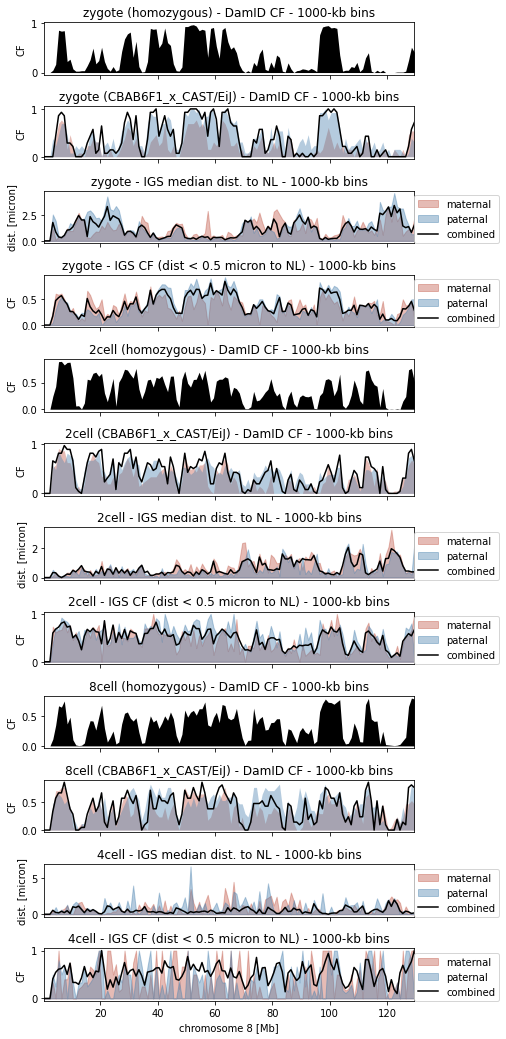

In [34]:
chrom = '8'
make_chrom_plot(chrom)

## chromosome 12 - distance to NL

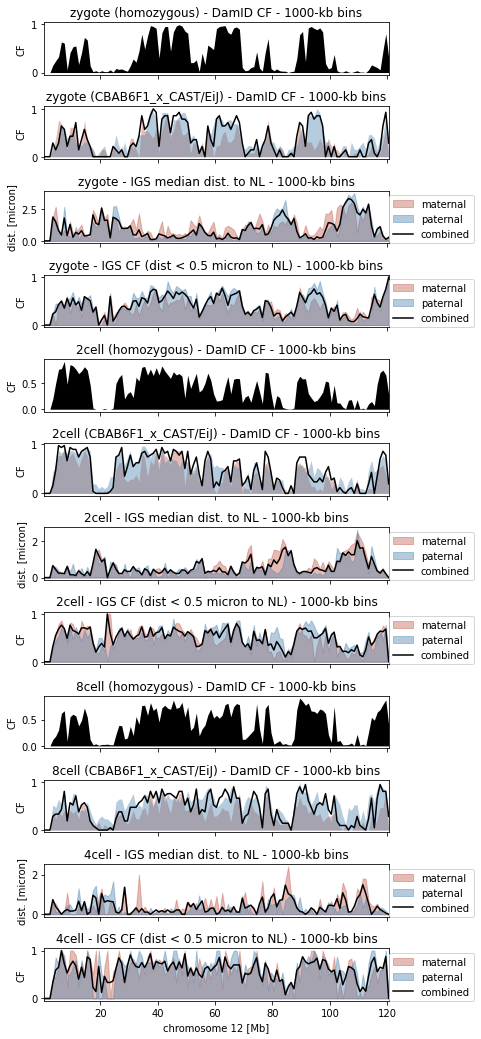

In [35]:
chrom = '12'
make_chrom_plot(chrom)

## chromosome 14 - distance to NL

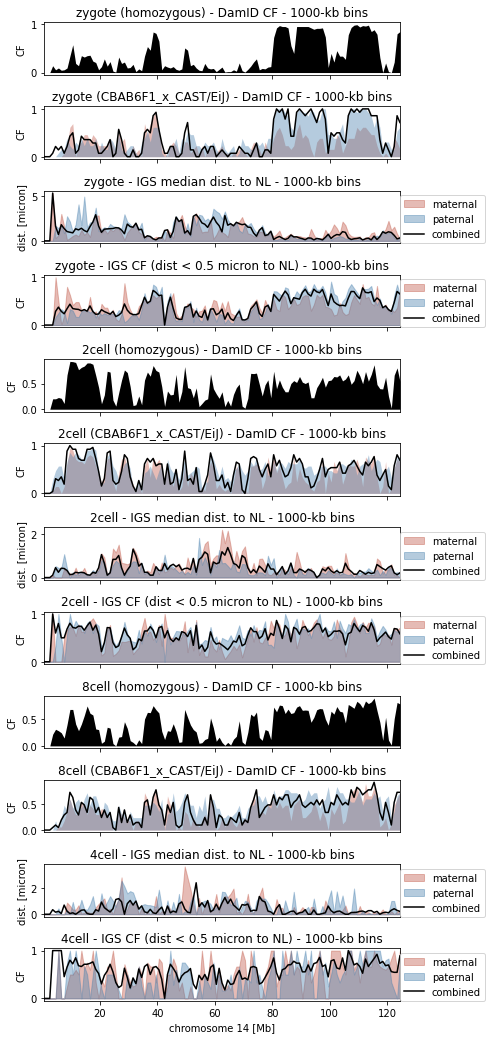

In [36]:
chrom = '14'
make_chrom_plot(chrom)

## chromosome X - distance to NL

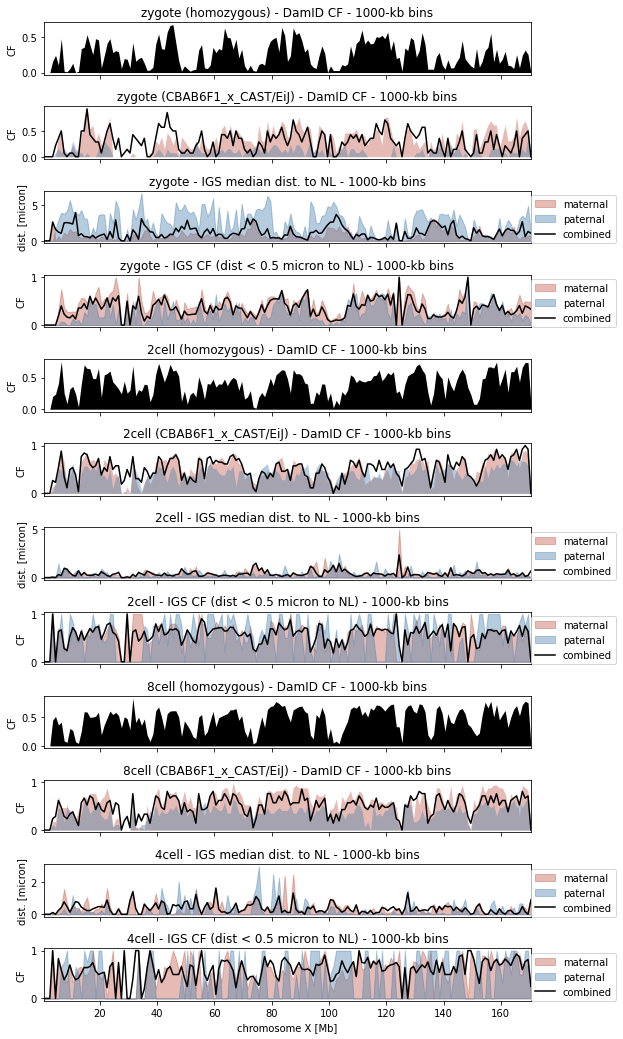

In [37]:
chrom = 'X'
make_chrom_plot(chrom)

# Distance to NPB

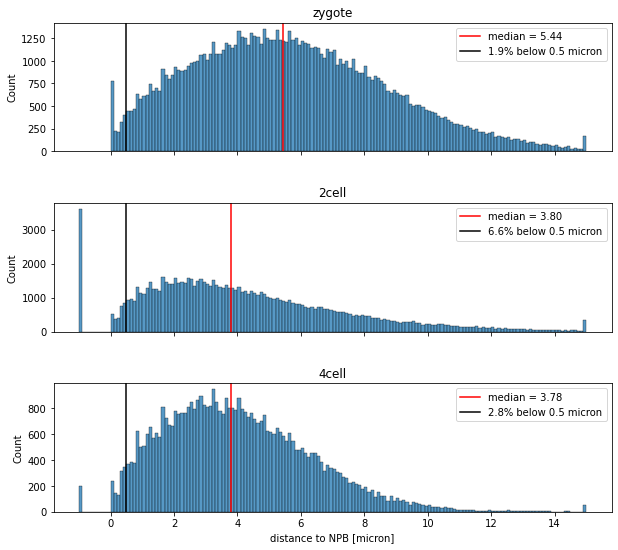

In [38]:
fig, axes = plt.subplots(3,1, figsize=(10,9), sharex=True)
plt.subplots_adjust(hspace=.4)

THRESH = NL_PROX_THRESH

for irow, stage in enumerate(['zygote', '2cell', '4cell']):
    to_plot = payne[(payne.stage==stage)].copy()
    
    ax = axes[irow]
    sns.histplot(to_plot['dist_to_npb'].clip(-5,15), ax=ax, binwidth=.1)
    ax.set_title(stage)
    ax.set_xlabel('distance to NPB [micron]')
    
    M = to_plot['dist_to_npb'].values
    M = M[M>0]
    M = np.median(M)
    ax.axvline(M, label='median = %.2f' % M, c='r')
    
    p = (to_plot['dist_to_npb'] < THRESH).mean()*100
    ax.axvline(THRESH, c='k', label='{:.1f}% below {:.1f} micron'.format(p, THRESH))
    
    ax.legend(loc='upper right')

# Distance to NPB along chromosome, comparison to NL CF
The comparison between NL-association and NPB-proximity is complicated by the fact that NPBs are generally further away from the NL. As a result, NL-associated is usually NPB-dital and vice versa, although no direct trafficking between the two locations is necessarily taking place.

## chromosome 8 - distance to NPB

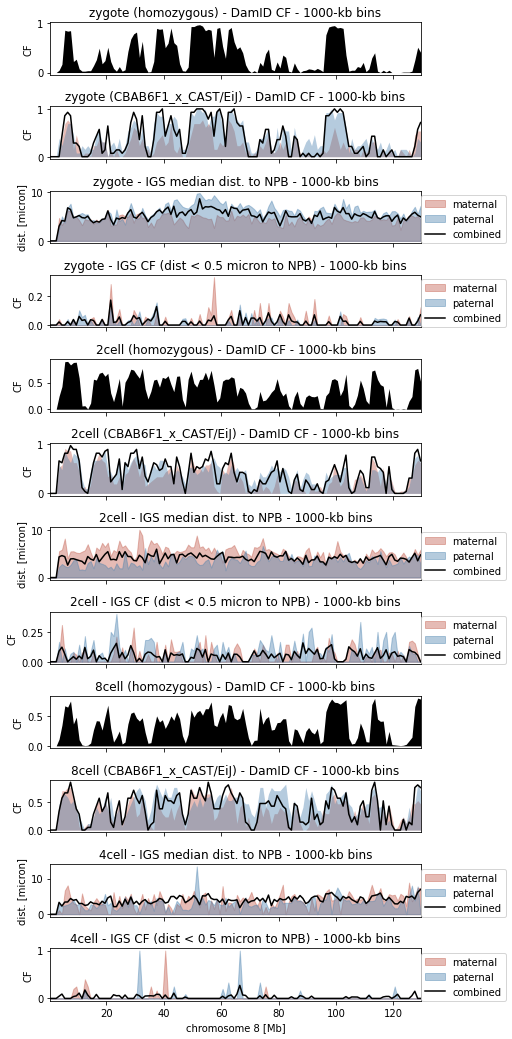

In [39]:
chrom = '8'
make_chrom_plot(chrom, feature='NPB')

## chromosome 14 - distance to NPB

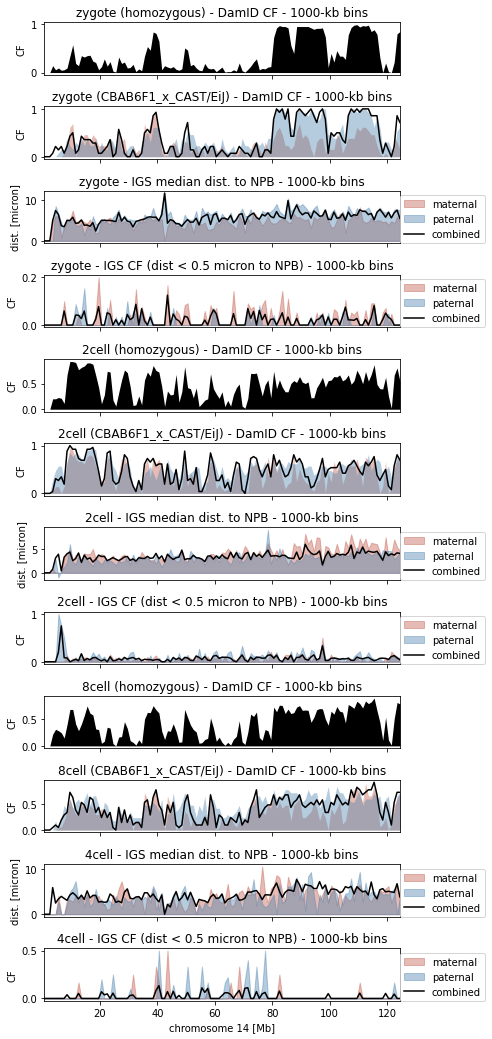

In [40]:
chrom = '14'
make_chrom_plot(chrom, feature='NPB')

## chromosome X - distance to NPB

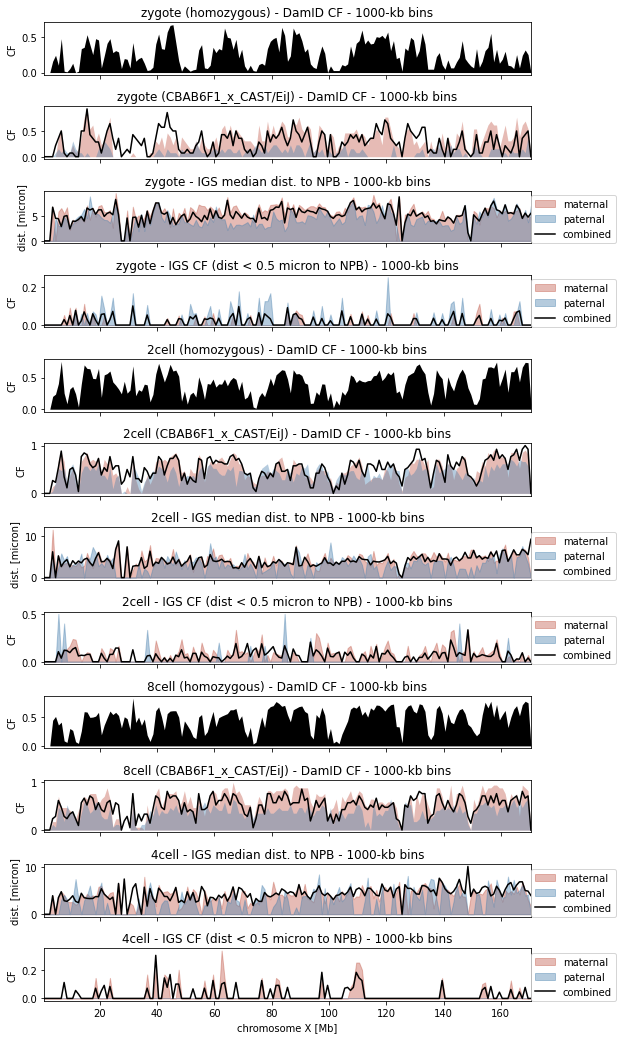

In [41]:
chrom = 'X'
make_chrom_plot(chrom, feature='NPB')

## Distance to NPB dependent on 

In [42]:
def make_chrom_plot(chrom, damid_binsize=100000):
    col = 'dist_to_npb'
    res = 1e6
    combine_as = 'median'
    thresh = NL_PROX_THRESH

    figw = 15 / len(mapab[damid_binsize]['1']) * len(mapab[damid_binsize][chrom])

    nrow = 11
    fig, axes = plt.subplots(nrow, 1, figsize=(figw, nrow*1.5), sharex=True)
    plt.subplots_adjust(hspace=.6)
    counter = 0

    for stage in ['zygote', '2cell', '4cell']:
        cf_stage = stage if stage != '4cell' else '8cell'
        genotypes = ['homozygous'] if cf_stage == '8cell' else ['homozygous', 'CBAB6F1_x_CAST/EiJ']

        # plot CF - DamID
        for gt in genotypes:
            ax = axes[counter]
            counter += 1
            
            Y = contact_freq[damid_binsize]['combined'][(cf_stage, gt)][chrom]
            X = (np.arange(0, len(Y)*damid_binsize, damid_binsize) + (damid_binsize/2)) / 1e6
            
            if gt == 'homozygous':
                ax.fill_between(X, 0, Y, color='k', lw=0)
            else:
                ax.plot(X, Y, c='k', label='combined')
                for allele in ['maternal', 'paternal']:
                    Y = contact_freq[damid_binsize][allele][(cf_stage, gt)][chrom]
                    clr = 'red' if allele == 'maternal' else 'blue'
                    ax.fill_between(X, 0, Y, alpha=0.2, color=clr, lw=0)
                    
            ax.set_title('%s (%s) - DamID CF - %d-kb bins' % (cf_stage, gt, int(damid_binsize/1000)))
            ax.set_xlim(X[0], X[-1])
            ax.set_ylabel('CF')

        # plot median dist to lamin

        for combine_as in ['median', 'CF']:
            ax = axes[counter]
            counter += 1

            for contact in ['contact', 'free']:
                if contact == 'free':
                    to_plot = payne[(payne.stage==stage) & (payne.chrom==chrom) & (payne.dist_to_lamin > .5)].copy()
                    to_plot = get_insilico_payne_track(to_plot, col, res, combine_as, thresh)
                else:
                    to_plot = payne[(payne.stage==stage) & (payne.chrom==chrom) & (payne.dist_to_lamin <= .5)].copy()
                    to_plot = get_insilico_payne_track(to_plot, col, res, combine_as, thresh)

                Y = to_plot.loc[to_plot.chrom==chrom, col].values
                X = (np.arange(0, len(Y)*res, res) + (res/2)) / 1e6
                ax.fill_between(X, 0, Y, alpha=.2, label=contact)

            N = 'NPB CF (dist < %.1f micron)' % thresh if combine_as == 'CF' else '%s dist. to NPB' % combine_as
            L = 'CF' if combine_as == 'CF' else 'dist. [micron]'
            ax.set_ylabel(L)
            ax.set_title('%s - IGS %s - %d-kb bins' % (cf_stage, N, int(res/1000)))
            ax.legend(loc=(1,0), title='NL association')
            if combine_as == 'CF':
                ax.set_ylim(0,.5)

    ax.set_xlabel('chromosome %s [Mb]' % chrom)
    plt.show()

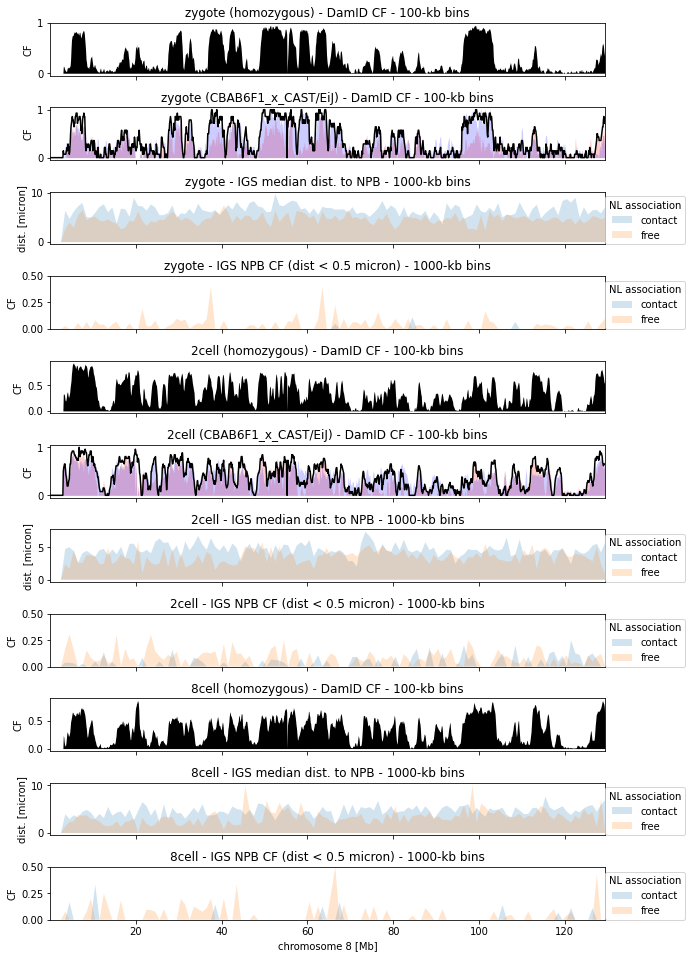

In [43]:
make_chrom_plot('8')

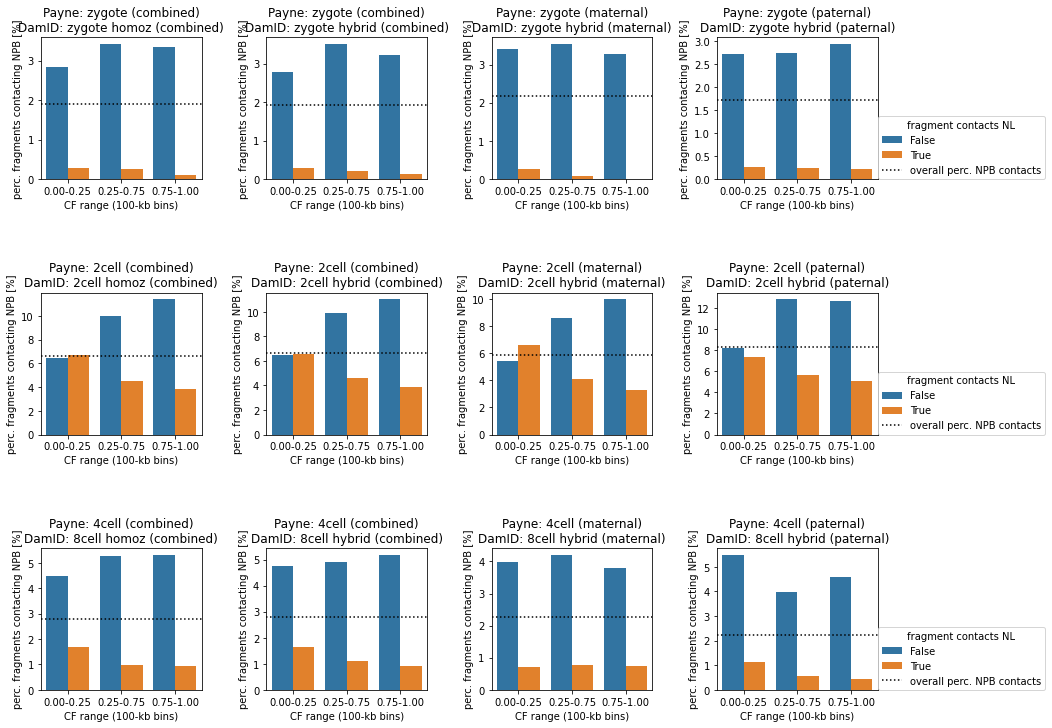

In [45]:
fig, axes = plt.subplots(3,4,figsize=(15,12))
plt.subplots_adjust(hspace=.8, wspace=.4)

NL_THRESH = NL_PROX_THRESH
NPB_THRESH = NL_PROX_THRESH
damid_binsize = 100000

for irow, stage in enumerate(['zygote', '2cell', '4cell']):

    
    for icol, allele in enumerate(['homozygous', 'combined', 'maternal', 'paternal']):
        
        # determine genotype and allele
        gt = 'homozygous' if allele == 'homozygous' else 'CBAB6F1_x_CAST/EiJ'
        allele = 'combined' if allele == 'homozygous' else allele
        
        # select relevant payne data
        ind = (payne.stage==stage) if allele == 'combined' else (payne.stage==stage) & (payne.allele==allele)
        to_plot = payne[ind].copy()
        to_plot['bin'] = (to_plot['pos'] // damid_binsize).astype(int)
    
        # iterate over chroms and collect CF
        damid_stage = stage if stage != '4cell' else '8cell'
        s = (damid_stage, gt)
        for chrom, df in to_plot.groupby('chrom'):

            to_plot.loc[df.index.values, 'CF'] = contact_freq[damid_binsize][allele][s][chrom][df['bin'].values]

        # divide CF values into categories
        cfvals = [0,0.25,0.75,1]
        for i in range(len(cfvals)-1):
            a, b = cfvals[i:i+2]
            n = '%.2f-%.2f' % (a,b)
            b = 1.1 if b == 1 else b
            ind = (to_plot.CF>= a) & (to_plot.CF<b)
            to_plot.loc[ind, 'CF_cat'] = n


        # compute fraction contacts per CF category
        to_plot['NL contact'] = to_plot.dist_to_lamin < NL_THRESH
        to_plot['NPB contact'] = to_plot.dist_to_npb < NPB_THRESH
        to_plot_mean = to_plot.groupby(['NL contact', 'CF_cat']).agg({'NPB contact': np.mean}).reset_index()
        to_plot_median = to_plot.groupby(['NL contact', 'CF_cat']).agg({'dist_to_npb': np.median}).reset_index()

        # plot 
        ax = axes[irow,icol]
        sns.barplot(
            hue=to_plot_mean['NL contact'], 
            y=to_plot_mean['NPB contact']*100, 
            x=to_plot_mean['CF_cat'], 
            ax=ax
        )
        
        exp = to_plot['NPB contact'].mean() * 100
        ax.axhline(exp, c='k', ls=':', label='overall perc. NPB contacts')
        if icol == 3:
            ax.legend(title='fragment contacts NL', loc=(1,0))
        else:
            ax.legend_.remove()



        gt_name = 'homoz' if gt == 'homozygous' else 'hybrid'
        title = 'Payne: %s (%s)\nDamID: %s %s (%s)' % (stage, allele, damid_stage, gt_name, allele)
        ax.set_title(title)
        ax.set_ylabel('perc. fragments contacting NPB [%]')
        ax.set_xlabel('CF range (%d-kb bins)' % int(damid_binsize/1e3))
#         ax.set_xticks(ax.get_xticks())
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

outfn = FIGOUTDIR + 'percentage_NPB_contacts_split_by_NL_contact_status.DamID_binsize_%d.pdf' % damid_binsize

## Contact matrices from Payne data

In [46]:
payne_contact_matrices = dict()
payne_distance_matrices = dict()

res = 1e6

for allele in ['maternal', 'paternal', 'combined']:
    payne_contact_matrices[allele] = dict()
    payne_distance_matrices[allele] = dict()
    
    for stage in payne.stage.unique():
        print(allele, stage)
        payne_contact_matrices[allele][stage] = dict()
        payne_distance_matrices[allele][stage] = dict()
    
        if allele == 'combined':
            ind = (payne.stage == stage)
        else:
            ind = (payne.stage == stage) & (payne.allele == allele)

        all_fragments = payne[ind].copy()
        all_fragments['bin'] = (all_fragments['pos'] // res).astype(int)
        all_fragments = all_fragments.sort_values(by=['cell_index', 'chrom', 'bin', 'pos']).reset_index(drop=True)
        cell_idx = all_fragments['cell_index'].unique()

        for chrom, df in all_fragments.groupby('chrom'):
            
            # perform randomization
            df_r = df.copy()
            c_ls = df_r['cell_index'].values
            np.random.seed(1)
            np.random.shuffle(c_ls)
            df_r['cell_index'] = c_ls
            df_r = df_r.sort_values(by=['cell_index', 'chrom', 'bin', 'pos']).reset_index(drop=True)

            # group fragments into genomic bins and use the minimal distance to NL as a metric
            bin_distances = df.groupby(['cell_index', 'bin']).agg({'dist_to_lamin': np.min}).reset_index()
            bin_distances['contact'] = bin_distances['dist_to_lamin'] < NL_PROX_THRESH
            bin_distances_r = df_r.groupby(['cell_index', 'bin']).agg({'dist_to_lamin': np.min}).reset_index()
            bin_distances_r['contact'] = bin_distances_r['dist_to_lamin'] < NL_PROX_THRESH
            samples = bin_distances['cell_index'].sort_values().unique()

            # initiate contact matrix
            ncells = len(cell_idx)
            nbins = bin_distances['bin'].max()+1
            D = np.zeros((ncells, nbins))
            D[:,:] = np.nan
            M = np.zeros((ncells, nbins))
            M[:,:] = np.nan
            Mr = np.zeros((ncells, nbins))
            Mr[:,:] = np.nan

            # iterate over cells and compute contacts
            for i, cid in enumerate(cell_idx):
                  
                ind = bin_distances['cell_index'] == cid
                if ind.sum() > 0:
                    tmp = bin_distances[ind].copy()
                    bin_ind = tmp['bin'].values

                    # add contacts to matrix
                    # contact = 1; no contact = 0; not obaserved = NA
                    M[i,bin_ind] = tmp['contact'].values.astype(int)
                    D[i,bin_ind] = tmp['dist_to_lamin'].values
                    
                
                # do same for randomized matrix
                ind = (bin_distances_r['cell_index'] == cid)
                if ind.sum() > 0:
                    tmp = bin_distances_r[ind].copy()
                    bin_ind = tmp['bin'].values
                    Mr[i,bin_ind] = tmp['contact'].values.astype(int)

            payne_contact_matrices[allele][stage][chrom] = M
            payne_contact_matrices[allele][stage]['samples'] = cell_idx
            payne_contact_matrices[allele][stage][(chrom, 'random')] = Mr
            
            payne_distance_matrices[allele][stage][chrom] = D
            payne_distance_matrices[allele][stage]['samples'] = cell_idx

maternal zygote
maternal 2cell
maternal 4cell
paternal zygote
paternal 2cell
paternal 4cell
combined zygote
combined 2cell
combined 4cell


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/18506683.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.pcolorfast(np.log10(M[sort_ind,:]), cmap='Reds')


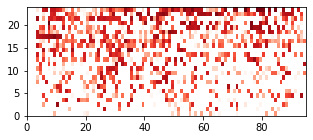

In [47]:
M = payne_distance_matrices['maternal']['zygote']['17']

fig, ax = plt.subplots(figsize=(5,2))

sort_ind = np.argsort(np.nansum(M, axis=1))

ax.pcolorfast(np.log10(M[sort_ind,:]), cmap='Reds')

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2927567858.py:9: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolorfast(np.log10(D[sort_ind,:]), cmap='viridis_r')


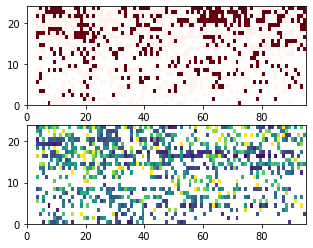

In [48]:
M = payne_contact_matrices['maternal']['zygote']['17']
D = payne_distance_matrices['maternal']['zygote']['17']

fig, axes = plt.subplots(2,1,figsize=(5,4))

sort_ind = np.argsort(np.nansum(M, axis=1))

axes[0].pcolorfast(M[sort_ind,:], cmap='Reds')
axes[1].pcolorfast(np.log10(D[sort_ind,:]), cmap='viridis_r')

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/3226742403.py:9: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolorfast(np.log10(D[sort_ind,:]), cmap='viridis_r')


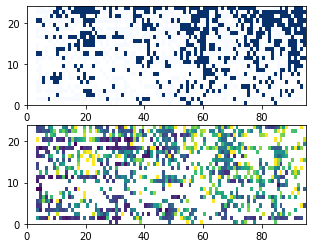

In [49]:
M = payne_contact_matrices['paternal']['zygote']['17']
D = payne_distance_matrices['paternal']['zygote']['17']

fig, axes = plt.subplots(2,1,figsize=(5,4))

sort_ind = np.argsort(np.nansum(M, axis=1))

axes[0].pcolorfast(M[sort_ind,:], cmap='Blues')
axes[1].pcolorfast(np.log10(D[sort_ind,:]), cmap='viridis_r')

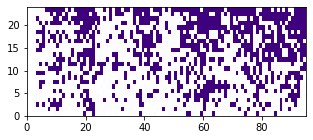

In [50]:
M = payne_contact_matrices['combined']['zygote']['17']

fig, ax = plt.subplots(figsize=(5,2))

sort_ind = np.argsort(np.nansum(M, axis=1))

ax.pcolorfast(M[sort_ind,:], cmap='Purples')

## Variability per allele - binary contact matrices

In [51]:
from collections import defaultdict

In [52]:
import itertools

In [53]:
results = defaultdict(list)

for stage in payne.stage.unique():

    for allele in ['maternal', 'paternal', 'combined']:
        print(stage, allele)
        
        cell_idx = payne_contact_matrices[allele][stage]['samples']
        cell_i = list(enumerate(cell_idx))
        Mdict = payne_contact_matrices[allele][stage]
        Ddict = payne_distance_matrices[allele][stage]
    
        for (i1, c1), (i2, c2) in itertools.combinations(cell_i, 2):

            contacts1 = np.concatenate([Mdict[c][i1,:] for c in chrom_order[:-2]])
            contacts2 = np.concatenate([Mdict[c][i2,:] for c in chrom_order[:-2]])
            
            random1 = np.concatenate([Mdict[(c,'random')][i1,:] for c in chrom_order[:-2]])
            random2 = np.concatenate([Mdict[(c,'random')][i2,:] for c in chrom_order[:-2]])
            
            dist1 = np.concatenate([Ddict[c][i1,:] for c in chrom_order[:-2]])
            dist2 = np.concatenate([Ddict[c][i2,:] for c in chrom_order[:-2]])
            
            results['stage'].append(stage)
            results['allele'].append(allele)
            results['cell_index_1'].append(c1)
            results['cell_index_2'].append(c2)
            results['n_fragments_1'].append((payne['cell_index']==c1).sum())
            results['n_fragments_2'].append((payne['cell_index']==c2).sum())
            results['n_contacts_1'].append(np.nansum(contacts1))
            results['n_contacts_2'].append(np.nansum(contacts2))
            results['n_random_1'].append(np.nansum(random1))
            results['n_random_2'].append(np.nansum(random2))
            
            # compute Yule's Q
            is_valid = (~np.isnan(contacts1)) & (~np.isnan(contacts2))
            is_same = (contacts1 == contacts2)
            is_diff = (contacts1 != contacts2)
            n_same = (is_same & is_valid).sum()
            n_diff = (is_diff & is_valid).sum()
            n_total = n_same + n_diff
            assert n_total == is_valid.sum()
            y = (n_same - n_diff) / n_total
            results['YulesQ'].append(y)
            
            # compute Jaccard
            a = (contacts1 == 1)
            b = (contacts2 == 1)
            j = (a & b).sum() / (a | b).sum()
            results['Jaccard'].append(j)
            
            # compute Spearman - distance
            filt = ~(np.isnan(dist1) | np.isnan(dist2))
            r, p = stats.spearmanr(dist1[filt], dist2[filt])
            results['Spearman_dist_rho'].append(r)
            results['Spearman_dist_pval'].append(p)
                
            # Yule's Q - random
            is_valid = (~np.isnan(random1)) & (~np.isnan(random2))
            is_same = (random1 == random2)
            is_diff = (random1 != random2)
            n_same = (is_same & is_valid).sum()
            n_diff = (is_diff & is_valid).sum()
            n_total = n_same + n_diff
            y = (n_same - n_diff) / n_total
            results['YulesQ_random'].append(y)
            
            # compute Jaccard - random
            a = (random1 == 1)
            b = (random2 == 1)
            j = (a & b).sum() / (a | b).sum()
            results['Jaccard_random'].append(j)
            
results = pd.DataFrame(results)

zygote maternal
zygote paternal
zygote combined
2cell maternal
2cell paternal
2cell combined
4cell maternal


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/3325022801.py:43: RuntimeWarning: invalid value encountered in long_scalars
  y = (n_same - n_diff) / n_total
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/3325022801.py:65: RuntimeWarning: invalid value encountered in long_scalars
  y = (n_same - n_diff) / n_total


4cell paternal
4cell combined


In [54]:
def plot_similarity(metric, min_fragments=1000):

    fig, axes  = plt.subplots(1,3,figsize=(12,4))
    plt.subplots_adjust(wspace=.4)

    rich_cells = payne.groupby(['cell_index']).size()
    rich_cells = rich_cells[rich_cells > min_fragments].index.values
    include_ind = results.cell_index_1.isin(rich_cells) & results.cell_index_2.isin(rich_cells)
    
    stat_df = defaultdict(list)
    
    for icol, stage in enumerate(['zygote', '2cell', '4cell']):

        df = results[include_ind & (results.stage == stage)].copy()
        ax = axes[icol]
        if len(df) == 0:
            ax.remove()
            continue

        sns.violinplot(
            x=df['allele'], y=df[metric], hue=df['allele'], dodge=False,
            order = ['maternal', 'paternal', 'combined'], palette = color_dict['allele'], ax = ax
        )
        
        # add information on sample numbers to plot
        xticklabs = list()
        for a in ['maternal', 'paternal', 'combined']:
            tmp = df[df.allele == a].copy()
            nsamples = len(np.unique(np.concatenate([tmp.cell_index_1.values, tmp.cell_index_2.values])))
            npairs = len(tmp)
            xticklabs.append('%s\nsamp=%d\npairs=%d' % (a, nsamples, npairs))
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(xticklabs)

        # performing statistical test - maternal v paternal
        n1 = (df.allele == 'maternal').sum()
        n2 = (df.allele == 'paternal').sum()
        if (n1 > 0) and (n2 > 0):
            tmp = df.copy()
            tmp = tmp[['cell_index_1', 'cell_index_2', 'allele', metric]]
            tmp = tmp.set_index(['cell_index_1', 'cell_index_2', 'allele']).unstack()
            M = tmp[(metric, 'maternal')].values
            P = tmp[(metric, 'paternal')].values
            
            w = stats.wilcoxon(M, P)

            # adding test result to plot
            ylim = ax.get_ylim()
            y = ylim[1] - 0.01*(ylim[1]-ylim[0])
            t = 'wilcoxon\np = %.2e' % w[1]
            ax.text(0.5, y, t, ha='center', va='top')
            
            tmp = tmp.reset_index()
            nsamples = len(np.unique(np.concatenate([tmp.cell_index_1.values, tmp.cell_index_2.values])))
            npairs = len(tmp)
            xticklabs.append('%s\nsamp=%d\npairs=%d' % (a, nsamples, npairs))
            
            stat_df['stage'].append(stage)
            stat_df['metric'].append(metric)
            stat_df['n_samples'].append(nsamples)
            stat_df['n_pairs'].append(npairs)
            stat_df['mean_mat'].append(np.mean(M))
            stat_df['mean_pat'].append(np.mean(P))
            stat_df['median_mat'].append(np.median(M))
            stat_df['median_pat'].append(np.median(P))
            stat_df['std_mat'].append(np.std(M))
            stat_df['std_pat'].append(np.std(P))
            stat_df['Wilcoxon_stat'].append(w[0])
            stat_df['Wilcoxon_pval'].append(w[1])
            

        title_add = 'cells with >%d fragments' % min_fragments
        lab_add = 'cell-cell similarity '
        # setting y-label
        if 'Spearman' in metric:
            ax.set_ylabel(lab_add + '[Spearman\'s rho]')
            ax.set_title('%s\nCorrelation of distance to NL\n%s - 1Mb bins' % (stage, title_add))
        elif 'Yule' in metric:
            ax.set_ylabel(lab_add + '[Yule\'s Q]')
            ax.set_title('%s\nYule\'s Q of NL contacts\n%s - 1Mb bins' % (stage, title_add))
        elif 'Jaccard' in metric:
            ax.set_ylabel(lab_add + '[Jaccard index]')
            ax.set_title('%s\nJaccard index of NL contacts\n%s - 1Mb bins' % (stage, title_add))
            
    stat_df = pd.DataFrame(stat_df)
    return stat_df

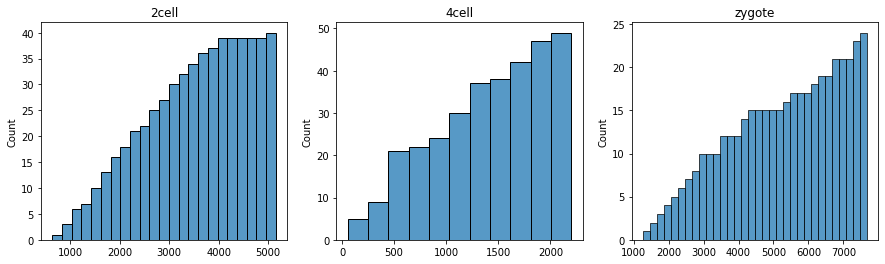

In [55]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
counter = 0

for stage, df in payne.groupby('stage'):
    ax = axes[counter]
    counter += 1
    
    ax.set_title(stage)
    
    n = df.groupby('cell_index').size()
    sns.histplot(n, binwidth=200, ax=ax, cumulative=True)

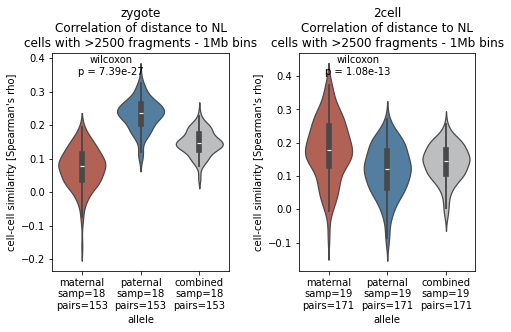

In [56]:
metric = 'Spearman_dist_rho'
stat_df = plot_similarity(metric, 2500)

outfn = FIGOUTDIR + 'cell-cell_similarity.Spearman_correlation_of_dist_to_NL.binsize_1000000.pdf'
plt.savefig(outfn, bbox_inches='tight')
outfn = outfn.replace('.pdf', '.tsv')
stat_df.to_csv(outfn, header=False, index=True, sep='\t')

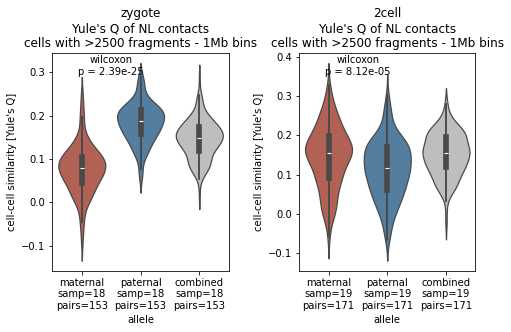

In [57]:
metric = 'YulesQ'
stat_df = plot_similarity(metric, 2500)

outfn = FIGOUTDIR + 'cell-cell_similarity.YulesQ_of_NL_contacts.binsize_1000000.pdf'
plt.savefig(outfn, bbox_inches='tight')
outfn = outfn.replace('.pdf', '.tsv')
stat_df.to_csv(outfn, header=False, index=True, sep='\t')

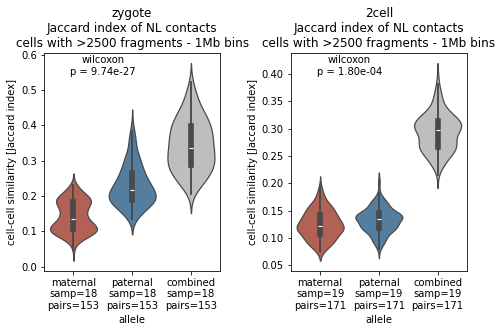

In [58]:
metric = 'Jaccard'
stat_df = plot_similarity(metric, 2500)

## Comparing Payne CF across cells versus CF across fragments - tracks

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


18


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


18


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


18


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


19


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


19


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/2440150617.py:28: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(M, axis=0)


19


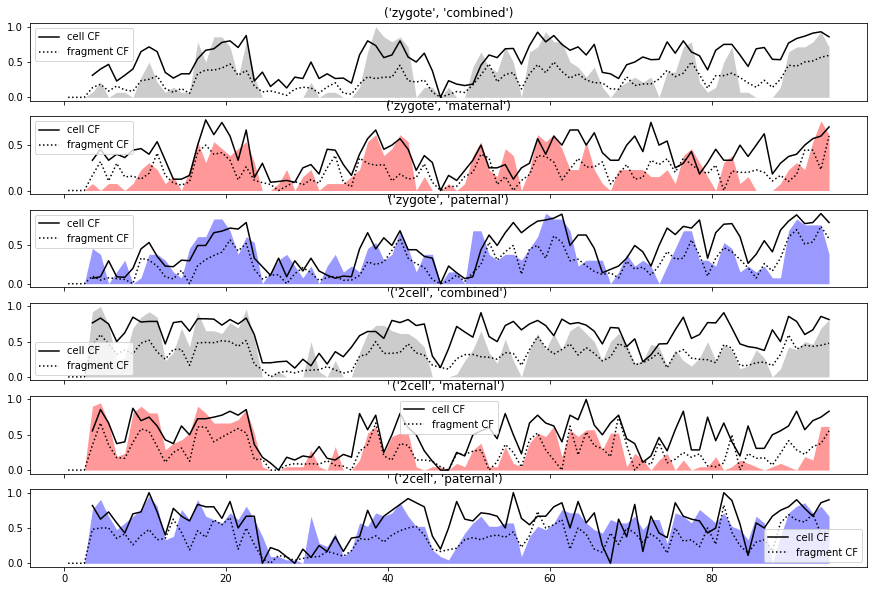

In [61]:
chrom = '17'
damid_binsize = 1000000
rich_cells = payne.groupby(['cell_index']).size()
rich_cells = rich_cells[rich_cells > 2500].index.values

fig, axes = plt.subplots(6,1,figsize=(15,10), sharex=True)
counter = 0

for stage in ['zygote', '2cell']:
    
    for allele in ['combined', 'maternal', 'paternal']:
        
        ax = axes[counter]
        counter += 1
        ax.set_title((stage, allele))
        
        # plot DamID CF
        Y = contact_freq[damid_binsize][allele][(stage, 'CBAB6F1_x_CAST/EiJ')][chrom]
        X = (np.arange(0, len(Y)) + 0.5) * damid_binsize / 1e6
        
        clr = {'maternal': 'r', 'paternal': 'b', 'combined': 'grey'}[allele]
        ax.fill_between(X, 0, Y, color=clr, alpha=0.4, lw=0)
        
        # plot 1
        samples = payne_contact_matrices[allele][stage]['samples']
        select_rich = np.isin(samples, rich_cells)
        M = payne_contact_matrices[allele][stage][chrom][select_rich,:]
        Y = np.nanmean(M, axis=0)
        X = (np.arange(0, len(Y)) + 0.5) * res / 1e6
        ax.plot(X, Y, color='k', label='cell CF')
        
        # plot 2
        if allele == 'combined':
            select_ind = (payne.stage == stage) 
        else:
            select_ind = (payne.stage == stage) & (payne.allele == allele)
               
        to_plot = get_insilico_payne_track(payne[select_ind].copy(), 'dist_to_lamin', res, 'CF', 0.2)
        Y = to_plot.loc[to_plot['chrom']==chrom, 'dist_to_lamin'].values
        X = (np.arange(0, len(Y)) + 0.5) * res / 1e6
        ax.plot(X, Y, color='k', ls=':', label='fragment CF')
        
        ax.legend()
        print(select_rich.sum())
        
        
        
        
        

## Comparing CF distributions

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])


zygote maternal 0.75 18 0.35020242914979755
zygote paternal 0.75 18 0.6942081814499798
zygote combined 0.75 18 0.9481781376518219
2cell maternal 0.475 19 0.10980551053484602
2cell paternal 0.475 19 0.09116693679092383


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/45121281.py:30: RuntimeWarning: Mean of empty slice
  cf = np.concatenate([np.nanmean(M[c][select_rich,

2cell combined 0.475 19 0.8654781199351702
4cell maternal 0.0 0 0.0
4cell paternal 0.0 0 0.0
4cell combined 0.0 0 0.0


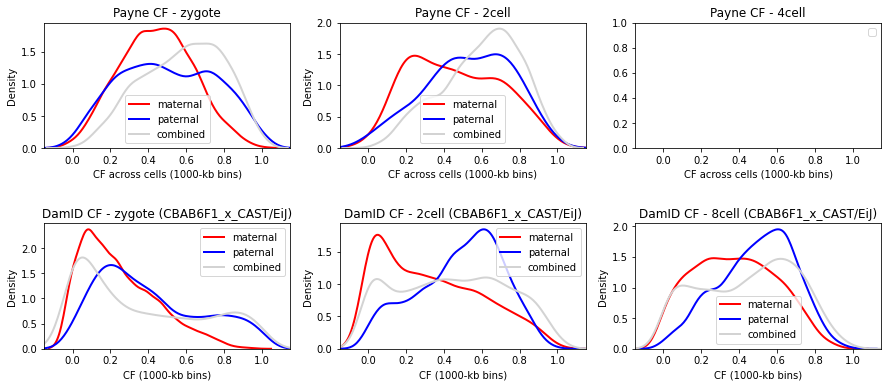

In [62]:
fig, axes = plt.subplots(2,3,figsize=(15,6))
plt.subplots_adjust(hspace=0.6)

rich_cells = payne.groupby(['cell_index']).size()
rich_cells = rich_cells[rich_cells > 2500].index.values
across_cells = True

damid_binsize = int(1e6)

for icol, stage in enumerate(['zygote', '2cell', '4cell']):
    
    ax0 = axes[0,icol]
    ax0.set_title('Payne CF - %s' % stage)
    
    ax1 = axes[1,icol]
    damid_stage = (stage, 'CBAB6F1_x_CAST/EiJ') if stage != '4cell' else ('8cell', 'CBAB6F1_x_CAST/EiJ')
    ax1.set_title('DamID CF - %s (%s)' % damid_stage)
    
    for allele in ['maternal', 'paternal', 'combined']:
        
        if across_cells:
            ### OPTION 1: CF across cells ###
            M = payne_contact_matrices[allele][stage]
            samples = M['samples']

            # select only rich cells:
            select_rich = np.isin(samples, rich_cells)

            n = np.concatenate([(~np.isnan(M[c][select_rich,:])).sum(axis=0) for c in chrom_order[:-2]])
            cf = np.concatenate([np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]])
            cf = cf[n>10]
            print(stage, allele, select_rich.mean(), select_rich.sum(), (n>10).mean())
            ax0.set_xlabel('CF across cells (%d-kb bins)' % int(res/1e3))
        
        else:
            ### OPTION 2: CF across fragments ###
            if allele == 'maternal':
                select_ind = (payne.stage == stage) & (payne['cluster_hap_imputed'] == 0)
            elif allele == 'paternal':
                select_ind = (payne.stage == stage) & (payne['cluster_hap_imputed'] == 1)
            else:
                select_ind = (payne.stage == stage)    
            to_plot = get_insilico_payne_track(payne[select_ind].copy(), 'dist_to_lamin', 1e6, 'CF', 0.2)
            to_plot = to_plot[(to_plot.n_fragments>10) & (to_plot.chrom.isin(chrom_order[:-2]))]

            cf = to_plot['dist_to_lamin'].values
            ax0.set_xlabel('CF across fragments (%d-kb bins)' % int(res/1e3))
        

        clr = {'maternal': 'red', 'paternal': 'blue', 'combined': 'lightgrey'}[allele]
        sns.kdeplot(cf, ax=ax0, label=allele, color=clr, lw=2)
        
        ### DamID CF ###
        if damid_stage not in contact_freq[damid_binsize][allele]:
            print(damid_stage)
            continue
            
        cf = np.concatenate([contact_freq[damid_binsize][allele][damid_stage][c] for c in chrom_order[:-2]])
        m_ind = np.concatenate([mapab[damid_binsize][c] for c in chrom_order[:-2]]) > (MINMAP_PER_KB*damid_binsize/1e3)
        cf = cf[m_ind]
        sns.kdeplot(cf, ax=ax1, label=allele, color=clr, lw=2)
        ax1.set_xlabel('CF (%d-kb bins)' % int(damid_binsize/1e3))
    
for ax in axes.flatten():
    ax.legend()
    ax.set_xlim(-0.15, 1.15)

## Correlating CFs

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_or

zygote maternal 13 17 13
zygote paternal 13 19 13
zygote combined 14 24 14
zygote combined 107 24 24
2cell maternal 21 23 21
2cell paternal 21 21 21
2cell combined 26 32 26
2cell combined 197 32 32


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/1522973698.py:36: RuntimeWarning: Mean of empty slice
  cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}


4cell maternal 17 16 16
4cell paternal 17 16 16
4cell combined 21 28 21
4cell combined 183 28 28


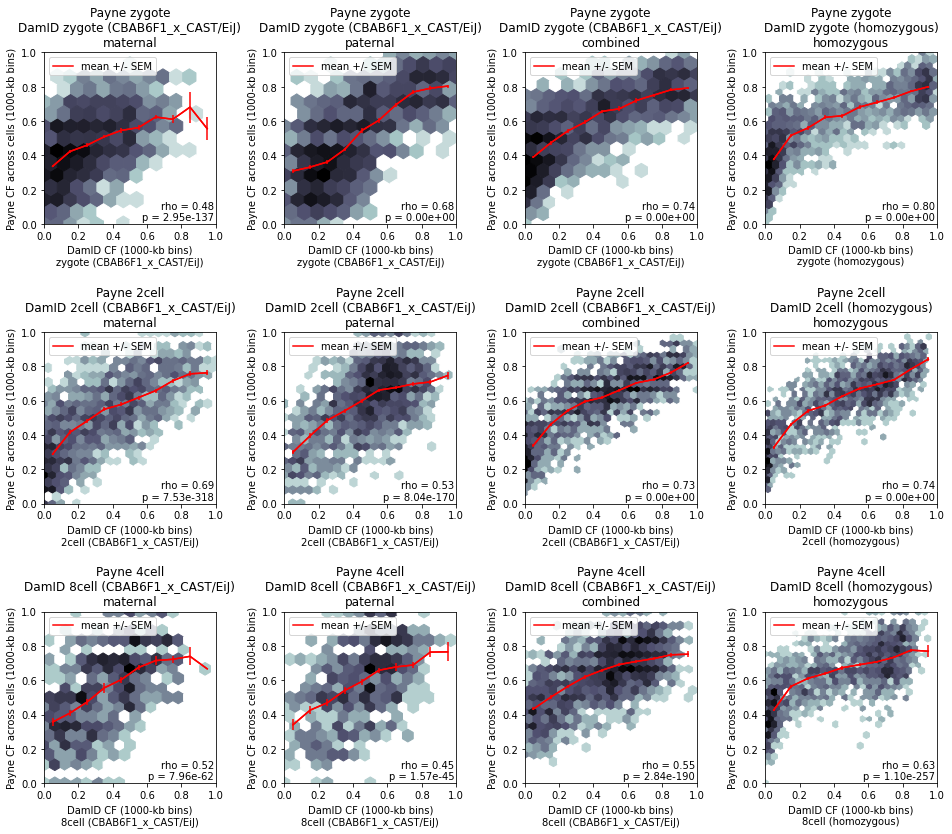

In [63]:
nrow = 3
ncol = 4
fig, axes = plt.subplots(nrow,ncol,figsize=(ncol*4,nrow*4.5))
plt.subplots_adjust(hspace=0.6, wspace=.4)

rich_cells = payne.groupby(['cell_index']).size()
rich_cells = rich_cells[rich_cells > 0].index.values
across_cells = True

damid_binsize = int(1e6)

for irow, stage in enumerate(['zygote', '2cell', '4cell']):
    damid_stage = stage if stage != '4cell' else '8cell'

    for icol, allele in enumerate(['maternal', 'paternal', 'combined', 'homozygous']):
        
        ax = axes[irow,icol]
        
        damid_sample = (damid_stage, 'CBAB6F1_x_CAST/EiJ') if allele != 'homozygous' else (damid_stage, 'homozygous')
        ax.set_title('Payne %s\nDamID %s (%s)\n%s' % (stage, damid_sample[0], damid_sample[1],allele))
        allele = allele if allele != 'homozygous' else 'combined'
        
        if across_cells:
            ### OPTION 1: CF across cells ###
            M = payne_contact_matrices[allele][stage]
            samples = M['samples']

            # select only rich cells:
            select_rich = np.isin(samples, rich_cells)
            
            if len(select_rich) == 0:
                ax.remove()
                continue

            n = {c: (~np.isnan(M[c][select_rich,:])).sum(axis=0) for c in chrom_order[:-2]}
            cfpayne = {c: np.nanmean(M[c][select_rich,:], axis=0) for c in chrom_order[:-2]}
            ylab = 'CF across cells'

        else:
            ### OPTION 2: CF across fragments ###
            if allele == 'combined':
                select_ind = (payne.stage == stage) 
            else:
                select_ind = (payne.stage == stage) & (payne['allele'] == allele)
            if select_ind.sum() == 0:
                ax.remove()
                continue
            to_plot = get_insilico_payne_track(payne[select_ind].copy(), 'dist_to_lamin', 1e6, 'CF', 0.2)
            
            cfpayne = {c: to_plot.loc[to_plot.chrom==c,'dist_to_lamin'].values for c in chrom_order[:-2]}
            n = {c: to_plot.loc[to_plot.chrom==c,'n_fragments'].values for c in chrom_order[:-2]}
            ylab = 'CF across fragments'

        
        ### DamID CF ###
        if damid_sample not in contact_freq[damid_binsize][allele]:
            print(allele, damid_sample)
            continue
            
        X = list()
        Y = list()
        for chrom in chrom_order[:-2]:
            x = contact_freq[damid_binsize][allele][damid_sample][chrom]
            y = cfpayne[chrom]
            
            f1 = n[chrom] > 5
            f2 = mapab[damid_binsize][chrom] > (MINMAP_PER_KB*damid_binsize/1e3)
            f3 = allele_filt_gt[damid_binsize][damid_sample[1]][chrom] if allele != 'combined' else f2
            
            l = min(len(x), len(y))
            f = f1[:l] & f2[:l]
            
            X.append(x[:l][f])
            Y.append(y[:l][f])
            
            
        X = np.concatenate(X)
        Y = np.concatenate(Y)
        
        # determine max gridsize
        ind = (anno.stage == damid_sample[0]) & (anno.genotype==damid_sample[1])
        ind = ind & anno.DamID_PASS if allele == 'combined' else ind & anno.DamID_PASS_allelic
        n_damid = ind.sum()
        n_payne = max(n['1'])
        
        gs = min(n_damid, n_payne)
        gs = max(gs, 10)
        print(stage, allele, n_damid, n_payne, gs)

        # plot hexbin
        ax.hexbin(X, Y, bins='log', extent=[0,1,0,1], gridsize=gs, mincnt=1, cmap='bone_r')
        ax.set_aspect('equal')
        
        # plot mean +/- sem
        tmp = pd.DataFrame({'damid': X, 'payne': Y})
        tmp['cat'] = (tmp['damid'] // 0.1).astype(int) * 0.1 + 0.05
        
        df_mean = tmp.groupby('cat').agg({'damid': np.mean, 'payne': np.mean})
        df_std = tmp.groupby('cat').agg({'damid': np.std, 'payne': np.std})
        df_sem = tmp.groupby('cat').agg({'damid': stats.sem, 'payne': stats.sem})
        
        x = tmp.groupby('cat').size().index.values
        y = df_mean['payne'].values
        
        s1 = df_sem['payne'].values
        s2 = df_sem['damid'].values
        
        ax.plot(x, y, '-', c='r', label='mean +/- SEM')
        ax.errorbar(x, y, yerr=s1, c='r')
        ax.legend(loc='upper left')
        
        # plot correlation
        r = stats.spearmanr(X, Y)
        t = 'rho = %.2f\np = %.2e' % r
        ax.text(0.99, 0.01, t, va='bottom', ha='right', transform=ax.transAxes)
        
        # set labels
        ax.set_xlabel('DamID CF (%d-kb bins)\n%s (%s)' % (int(damid_binsize/1e3), damid_sample[0], damid_sample[1]))
        ax.set_ylabel('Payne %s (%d-kb bins)' % (ylab, int(res/1e3)))
        
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    
outfn = FIGOUTDIR + 'CF_versus_CF.binsize_1000000.pdf'
plt.savefig(outfn)

## Contact at centromeric side - version 1

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/346233979.py:29: RuntimeWarning: Mean of empty slice
  CF = {c: np.nanmean(payne_contact_matrices[allele][stage][c][select_rich,:], axis=0) for c in chrom_order}


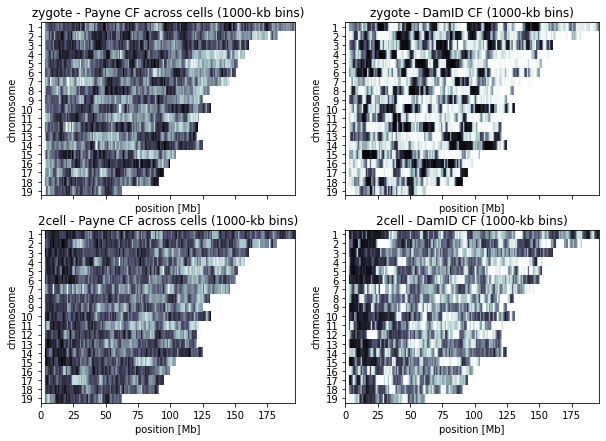

In [65]:
fig, axes = plt.subplots(2,2,figsize=(10,7), sharex=True)
counter = 0

rich_cells = payne.groupby(['cell_index']).size()
rich_cells = rich_cells[rich_cells > 1000].index.values
across_cells = True
allele = 'combined'
damid_binsize = int(1e6)

for irow, stage in enumerate(['zygote', '2cell']):
    
    damid_stage = (stage, 'homozygous')
    
    for icol, technique in enumerate(['Payne', 'DamID']):
        
        ax = axes[irow, icol]
        
    
        
        if technique == 'DamID':
            CF = contact_freq[damid_binsize][allele][(stage, 'homozygous')]
            ax.set_title('%s - DamID CF (%d-kb bins)' % (stage, int(damid_binsize/1e3)))

        else:
 
            if across_cells:
                samples = payne_contact_matrices[allele][stage]['samples']
                select_rich = np.isin(samples, rich_cells)
                CF = {c: np.nanmean(payne_contact_matrices[allele][stage][c][select_rich,:], axis=0) for c in chrom_order}
                ax.set_title('%s - Payne CF across cells (%d-kb bins)' % (stage, int(damid_binsize/1e3)))
                
            else:
                if allele == 'combined':
                    select_ind = (payne.stage == stage)  
                else:
                    select_ind = (payne.stage == stage) & (payne['allele'] == allele)
                      
                to_plot = get_insilico_payne_track(payne[select_ind].copy(), 'dist_to_lamin', res, 'CF', 0.2)
                CF = {c: df['dist_to_lamin'].values for c, df in to_plot.groupby('chrom')}
                ax.set_title('%s - Payne CF across fragments (%d-kb bins)' % (stage, int(damid_binsize/1e3)))
        
        chrl = list()
        for y, chrom in enumerate(chrom_order[:-2][::-1]):
            
            C = CF[chrom]
            C[np.isnan(C)] = 0
            extent = [0, len(C)*damid_binsize/1e6, y, y+1]
            C = np.atleast_2d(C)
            vmx = 1 if technique == 'Payne' else 1
            ax.imshow(C, extent=extent, origin='lower', aspect='auto', vmin=0, vmax=vmx, cmap='bone_r')
            chrl.append(extent[1])
            
        ax.set_ylim(0, y+1)
        ax.set_xlim(0, max(chrl))
        ax.set_yticks(np.arange(y+1)+.5)
        ax.set_yticklabels(chrom_order[:-2][::-1])
        ax.set_ylabel('chromosome')
        ax.set_xlabel('position [Mb]')
        
        
        
        
        

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/4286805110.py:37: RuntimeWarning: Mean of empty slice
  m = np.nanmean(payne_contact_matrices[allele][stage][c][select_rich,:], axis=0)
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/4286805110.py:76: RuntimeWarning: Mean of empty slice
  Ym = np.nanmean(Y, axis=0)


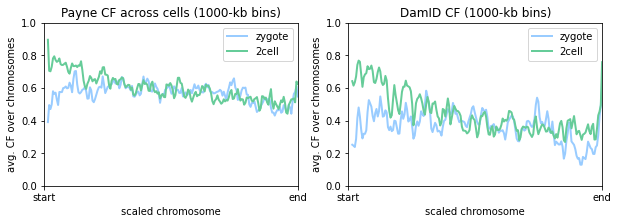

In [66]:
fig, axes = plt.subplots(1,2,figsize=(10,3), sharex=True)
counter = 0

rich_cells = payne.groupby(['cell_index']).size()
rich_cells = rich_cells[rich_cells > 0].index.values
across_cells = True
allele = 'combined'
damid_binsize = int(1e6)
rescale_whole = True

n_mb = 50
n_bins = int(n_mb * 1e6 / damid_binsize)

for stage in ['zygote', '2cell']:
    
    damid_stage = (stage, 'homozygous') if stage != '4cell' else ('8cell', 'homozygous')
    
    for icol, technique in enumerate(['Payne', 'DamID']):
        
        ax = axes[icol]

        
        if technique == 'DamID':
            CF = {c: np.copy(contact_freq[damid_binsize][allele][damid_stage][c]) for c in chrom_order}
            for c in chrom_order:
                ind = mapab[damid_binsize][c] < (MINMAP_PER_KB*damid_binsize/1e3)
                CF[c][ind] = np.nan
            ax.set_title('DamID CF (%d-kb bins)' % int(damid_binsize/1e3))

        else:
 
            if across_cells:
                samples = payne_contact_matrices[allele][stage]['samples']
                select_rich = np.isin(samples, rich_cells)
                CF = dict()
                for c in chrom_order:
                    m = np.nanmean(payne_contact_matrices[allele][stage][c][select_rich,:], axis=0)
                    ind = (~np.isnan(payne_contact_matrices[allele][stage][c][select_rich,:])).sum(axis=0) > 10
                    m[~ind] = np.nan
                    CF[c] = m
                ax.set_title('Payne CF across cells (%d-kb bins)' % int(damid_binsize/1e3))
                
            else:
                if allele == 'maternal':
                    select_ind = (payne.stage == stage) & (payne['cluster_hap_imputed'] == 0)
                elif allele == 'paternal':
                    select_ind = (payne.stage == stage) & (payne['cluster_hap_imputed'] == 1)
                else:
                    select_ind = (payne.stage == stage)    
                to_plot = get_insilico_payne_track(payne[select_ind].copy(), 'dist_to_lamin', res, 'CF', 0.2)
                CF = {c: df['dist_to_lamin'].values for c, df in to_plot.groupby('chrom')}
                n = {c: df['n_fragments'].values for c, df in to_plot.groupby('chrom')}
                for c in chrom_order:
                    CF[c][n[c] < 10] = np.nan
                ax.set_title('Payne CF across fragments (%d-kb bins)' % int(damid_binsize/1e3))
        
        if rescale_whole:
            Y = list()
            for c in chrom_order[:-2]:
                y = CF[c]
                ind = np.isnan(y)
                y[ind] = 0
                y = scipy.signal.resample(y, 200)
                ind = scipy.signal.resample(ind, 200) > 0.2
                y[ind] = np.nan
                Y.append(y)
            X = np.arange(200)
            xlab = 'scaled chromosome'
            ax.set_xticks([X[0],X[-1]])
            ax.set_xticklabels(['start', 'end'])
#             Y = np.array([scipy.signal.resample(CF[c], 200) for c in chrom_order[:-2]])
        else:
            Y = np.array([CF[c][:n_bins] for c in chrom_order[:-2]])
            X = np.arange(0, n_bins)*damid_binsize/1e6
            xlab = 'position [Mb]'
        Ym = np.nanmean(Y, axis=0)
        
        ax.plot(X, Ym, label=stage, color=color_dict['stage'][stage], lw=2)     
        ax.set_ylim(0,1)
        ax.set_xlim(0, X[-1])
        ax.set_xlabel(xlab)
        ax.set_ylabel('avg. CF over chromosomes')
        ax.legend()
        
outfn = FIGOUTDIR + 'average_CF_over_scaled_chromosomes.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Fraction contact in genome

In [67]:
NL_PROX_THRESH

0.5

In [68]:
def plot_fraction_contact_with_NL(res):
    
    # select data
    to_plot = payne.copy()
    to_plot['stage'] = to_plot['stage'].values.astype(str)
    to_plot = to_plot[~to_plot.chrom.isin(['X','Y'])]
    to_plot = to_plot[to_plot.allele.isin(['maternal','paternal'])]
    
    # determine minimum distance to the NL per bin for each sample
    to_plot['bin'] = (to_plot['pos'] // res).astype(int)
    to_plot = to_plot.groupby(['stage', 'cell_index', 'allele', 'chrom', 'bin']).agg({'dist_to_lamin': np.nanmin}).reset_index()
    
    # determine which bins contact the NL
    to_plot['NL_contact'] = (to_plot['dist_to_lamin'] < NL_PROX_THRESH)
    to_plot = to_plot[~to_plot.dist_to_lamin.isna()]

    # determine per cell the fraction of bins at the NL
    df = to_plot.groupby(['stage', 'allele', 'cell_index']).agg({'NL_contact': np.mean}).reset_index()

    # plot results
    fig, ax = plt.subplots(figsize=(4,3))
    sns.violinplot(
        x=df['stage'], y=df['NL_contact'], hue=df['allele'], palette=color_dict['allele'],
        ax=ax, cut=0, order=['zygote', '2cell', '4cell']
    )
    ax.set_title('Fraction contact with NL (<%.2f micron); binsize = %.0f kb' % (NL_PROX_THRESH, (res/1000)))
    ax.set_xlabel('stage')
    ax.set_ylabel('fraction')
    
    # do statistical test
    stat_df = defaultdict(list)
    y = ax.get_ylim()[0] + 0.01
    for x, stage in enumerate(['zygote', '2cell', '4cell']):
        tmp = df[df.stage==stage].copy()
        tmp = tmp.set_index(['stage', 'cell_index', 'allele']).unstack()
        tmp.columns = [c[1] for c in tmp.columns.values]
        
        A = tmp['maternal'].values
        B = tmp['paternal'].values
        s, p = stats.wilcoxon(A, B)
        t = 'p=%.2e' % p
        ax.text(x, y, t, ha='center', va='bottom')
        
        stat_df['stage'].append(stage)
        stat_df['binsize'].append(int(res))
        stat_df['n_samples'].append(len(A))
        stat_df['mean_mat'].append(np.mean(A))
        stat_df['mean_pat'].append(np.mean(B))
        stat_df['median_mat'].append(np.median(A))
        stat_df['median_pat'].append(np.median(B))
        stat_df['std_mat'].append(np.std(A))
        stat_df['std_pat'].append(np.std(B))
        stat_df['Wilcoxon_stat'].append(s)
        stat_df['Wilcoxon_pval'].append(p)
    stat_df = pd.DataFrame(stat_df)
    
    plt.show()
    plt.close()
    
    return stat_df
    

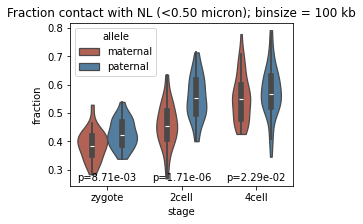

<Figure size 432x288 with 0 Axes>

In [69]:
res = 1e5
stat_df = plot_fraction_contact_with_NL(res)

outfn = FIGOUTDIR + 'fraction_contact_with_NL.binsize_%d.pdf' % int(res)
plt.savefig(outfn, bbox_inches='tight')
outfn = outfn.replace('.pdf', '.tsv')
stat_df.to_csv(outfn, header=True, index=False, sep='\t')

# Coordination

In [72]:
# R = np.zeros((M.shape[1], M.shape[1]))

# for i in range(M.shape[1]):
#     a = M[:,i]
#     for j in range(M.shape[1]):
#         b = M[:,j]
        
#         if ((~np.isnan(a)) & (~np.isnan(b))).sum() < 2:
#             R[i,j] = np.nan
#             continue
        
#         valid_a = (a == 1) & (~np.isnan(b))
#         valid_b = (~np.isnan(a)) & (b == 1)
#         u = valid_a | valid_b
#         o = valid_a & valid_b
        
#         R[i, j] = o.sum()/u.sum()
        
# fig, ax = plt.subplots(1,1)
# p = ax.pcolorfast(R, cmap='Reds', vmin=0, vmax=1)
# plt.colorbar(p, ax=ax)
# ax.set_aspect('equal')
        

## Coordinated NL interactions?

In [73]:
# stage = 'zygote'
# chrom = '13'
# start = 84e6
# end = 85e6

# fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True)

# ax = axes[0]

# Y = contact_freq[stage][chrom]
# X = np.arange(0, len(Y)*BINSIZE, BINSIZE) + BINSIZE/2

# ax.fill_between(X, 0, Y, color='grey')
# ax.axvline(start, c='k')
# ax.axvline(end, c='k')
# ax.set_xlim(X[0], X[-1])
# ax.set_ylabel('CF')
# ax.set_title(stage)


# to_plot = payne[(payne.stage==stage) & (payne.chrom==chrom) & (payne.pos > start) & (payne.pos < end)].copy()
# to_plot['cell_id'] = to_plot.apply(axis=1, func = lambda r: '%d.%d' % (r['embryo_id'], r['cell_id']))
# fig1, ax1 = plt.subplots()
# # sns.stripplot(x=to_plot['cell_id'], y=to_plot['dist_to_lamin'], ax=ax1)
# tmp = to_plot.groupby('cell_id').agg({'dist_to_lamin':np.mean}).reset_index()
# sns.stripplot(x=tmp['cell_id'], y=tmp['dist_to_lamin'], ax=ax1, color='k')
# ax1.axhline(.5)

# eid_with_contact = tmp.loc[tmp.dist_to_lamin < .5, 'cell_id'].values
# eid_no_contact = tmp.loc[tmp.dist_to_lamin >= .5, 'cell_id'].values


# res = 1e6

# ax = axes[1]
# for name, eid in {'with contact': eid_with_contact, 'without contact': eid_no_contact}.items():
#     df = payne[payne.chrom==chrom].copy()
#     df['cell_id'] = df.apply(axis=1, func = lambda r: '%d.%d' % (r['embryo_id'], r['cell_id']))
#     df = df[df.cell_id.isin(eid)].copy()
#     df['bin'] = df['pos'] // res
#     df_mean = df.groupby('bin').agg({'dist_to_lamin': np.mean}).reset_index()
    
#     X = df_mean['bin'].values * res + (res/2)
#     Y = df_mean['dist_to_lamin'].values
#     ax.plot(X, Y, label=name)
    
    
# ax.legend()
# ax.axvline(start, c='k')
# ax.axvline(end, c='k')
# ax.axhline(.5, c='k', ls=':')
# ax.set_xlabel('chromosome %s' % chrom)

# Plotting single-cell pairwise contacts

In [76]:
from sklearn.metrics import pairwise_distances

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/251408193.py:54: RuntimeWarning: divide by zero encountered in log2
  C = np.log2(D)


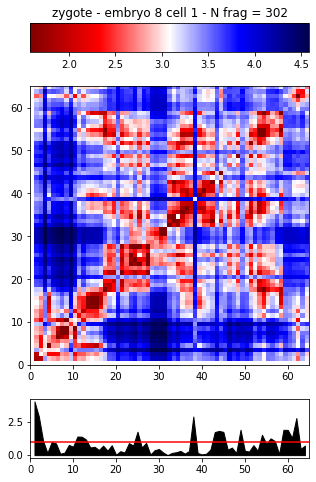

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/251408193.py:54: RuntimeWarning: divide by zero encountered in log2
  C = np.log2(D)


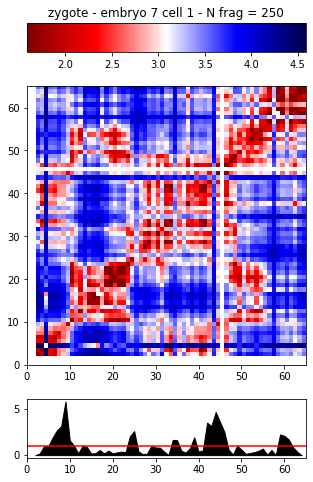

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/251408193.py:54: RuntimeWarning: divide by zero encountered in log2
  C = np.log2(D)


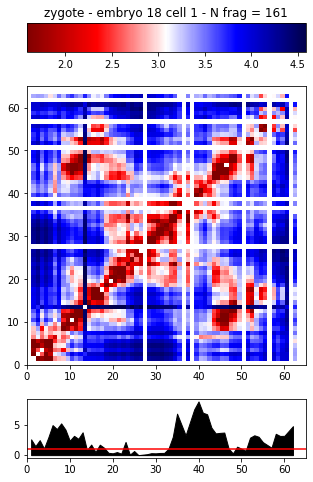

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/251408193.py:54: RuntimeWarning: divide by zero encountered in log2
  C = np.log2(D)


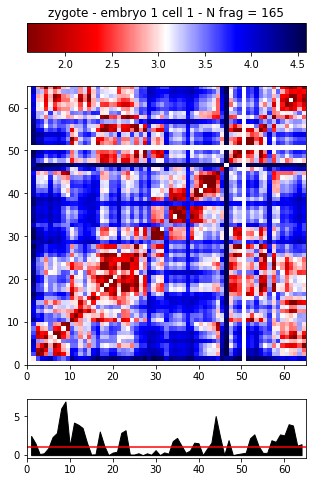

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_46598/251408193.py:54: RuntimeWarning: divide by zero encountered in log2
  C = np.log2(D)


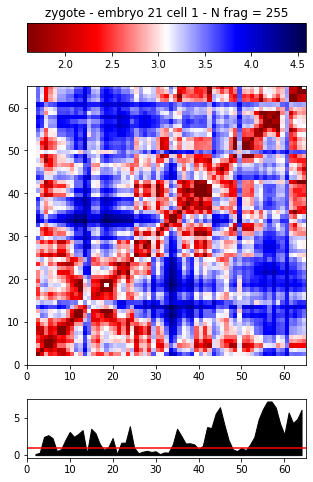

In [78]:
stage = 'zygote'
chrom = '8'
res = 2e6
allele = 'paternal'
damid_binsize = int(1e6)

df = payne[payne.stage==stage].groupby(['embryo_id', 'cell_id']).size().reset_index().rename(columns={0: 'N'})
eid, cid = df.sort_values(by='N')[['embryo_id', 'cell_id']].values[-1]
sorted_emb = df.sort_values(by='N')[['embryo_id', 'cell_id']].values[::-1][:5]

for (eid, cid) in sorted_emb:

    ind_emb = (payne.stage==stage) & (payne.embryo_id==eid) & (payne.cell_id==cid)
    ind_loc = (payne.chrom==chrom) & (payne.allele == allele)
    to_plot = payne[ind_emb & ind_loc].copy()
    to_plot['bin'] = (to_plot['pos'] // res).astype(int)
    to_plot = to_plot.sort_values(by='pos')
    
    if len(to_plot) == 0:
        continue
    
    Nfrag = len(to_plot)

    # cols = ['bin', 'x_um_abs', 'y_um_abs', 'z_um_abs', 'dist_to_lamin', 'dist_to_npb', 'dist_to_cen']
    # to_plot = to_plot[cols].groupby(['bin']).mean().reset_index()

    dist = pairwise_distances(to_plot[['x_um_abs', 'y_um_abs', 'z_um_abs']].values, metric='euclidean')
    dist = pd.DataFrame(dist, index=to_plot['pos'].values, columns=to_plot['pos'].values)

    df = dist.reset_index().rename(columns={'index':'pos_1'}).melt(id_vars='pos_1', var_name='pos_2', value_name='dist')
    df['bin_1'] = (df['pos_1'] // res).astype(int)
    df['bin_2'] = (df['pos_2'] // res).astype(int)

    df_binned = df.groupby(['bin_1', 'bin_2']).agg({'dist': np.mean})
    df_binned = df_binned.unstack()
    # df_binned.index = [c[1] for c in df_binned.index.values]
    df_binned.columns = [c[1] for c in df_binned.columns.values]

    L = int(np.ceil(len(mapab[damid_binsize][chrom]) * damid_binsize / res))
    D = np.zeros((L, L))
    D[:,:] = np.nan

    all_indices = df_binned.index.values
    for i in all_indices:
        D[i,all_indices] = df_binned.loc[i, all_indices].values



    fig, axes = plt.subplots(3,1,figsize=(5,8), gridspec_kw={'height_ratios': [1,10,2]})
    
    axes[0].set_title('%s - embryo %s cell %s - N frag = %d' % (stage, eid, cid, Nfrag))

    ax = axes[1]
    C = np.log2(D)
    p = ax.pcolorfast(C, cmap='seismic_r', vmin=np.log2(3), vmax=np.log2(24))
    cbar = plt.colorbar(p, cax=axes[0], orientation='horizontal')
    ax.set_aspect('equal')

    ax = axes[2]
    df = to_plot.groupby('bin').agg({'dist_to_lamin': np.mean}).reset_index()
    X = df['bin']
    Y = df['dist_to_lamin']
    ax.fill_between(X, Y, color='k')
    ax.set_xlim(0, X.max())
    ax.axhline(1, c='r')
    
    xrange = np.array([ax.get_xlim() for ax in axes[1:]])
    xmn = xrange.min(axis=0)[0]
    xmx = xrange.max(axis=0)[1]
    for ax in axes[1:]:
        ax.set_xlim(xmn, xmx)
    
    plt.show()
    plt.close()